In [282]:
# Imports
import os
import sys
print(sys.version)

# Primary data analysis modules
import h5py
import numpy as np
import pandas as pd

# General functionality
import math
import random
import re
import glob
from datetime import datetime

# Performance + memory checking
import time
import psutil
import resource

# Scipi/Sklearn
from scipy import stats
from scipy.stats import zscore
from scipy.spatial.distance import pdist, squareform
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

# Saving data
import pickle

# Plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

# Parallelization + performance
from functools import partial
import itertools
from collections import Counter
import multiprocessing as mp

# Threading
import threading
from threading import Lock
from concurrent.futures import ThreadPoolExecutor


# Dan neural data analysis helper functions
sys.path.append('/mnt/smb/locker/issa-locker/users/Dan/code')
from data_analysis_tools_mkTurk.IO import ch_dicts_2_h5, h5_2_trial_df, h5_2_df, find_im_full_paths
from mkutils_ddk.IO import sessions2spikes, find_h5_path
from data_analysis_tools_mkTurk.utils_meta import find_channels, get_recording_path, get_coords_sess, get_all_metadata_sess
from data_analysis_tools_mkTurk.stim_info import filter_stim_trials, expand_classes, get_class_trials
from data_analysis_tools_mkTurk.stim_info import create_trial_df, create_stim_idx_mat, reverse_lookup_rsvp_stim
from data_analysis_tools_mkTurk.stim_info import session_dicts_2_df, sess_meta_dict_2_df
from data_analysis_tools_mkTurk.npix import chs_meta_2_site_coords, h5_2_ch_meta, get_sess_metadata_path, extract_imro_table, get_site_coords
from data_analysis_tools_mkTurk.general import df_2_psth_mat, time_window2bin_indices, remove_duplicate_rsvp_indices, rsvp_from_df

# CNNs + Image processing
from PIL import Image
import torch
import torch.optim as optim
import torch.multiprocessing as tmp
import torchvision
from torchvision import transforms
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights

# Model loading + GPU Processing function (had access issues if written in code directly)
sys.path.append('/mnt/smb/locker/issa-locker/users/Parsa/code')
sys.path.append('/scratch/issa/users/spa2139/objectome_single')
from gpu_processing import process_batch
from load_model_ver3 import load_model as load_SL_model
from objectome_single.training import BarlowTwinsLightningModule, LatentPredictionLightningModule, ObjectClassificationLightningModule


3.11.4 (main, Jul  5 2023, 14:15:25) [GCC 11.2.0]


In [2]:
%autosave 300

Autosaving every 300 seconds


In [3]:
# Estimates of brain area depth from onshape:
'''
NEW PLAN: All major west areas ~.5 more depth from Dura than Bourgeois. Thus, three variables:
Bour IT = 2.5
West_IT (=bour_depth + .5)
MT_IT separation


OLD INFO:
Bourgeois
    H0 - IT: depth < 2.5, DV > 3.5~4 (had to get rid of DV because nothing left?)
    H1 - same depth, basically no DV (good until very low, consider if results bad)

West
    All IT depth < 3, can go up to 3.5/4 for H2 if need
    No clear DV restrictions yet, Younah's are off by 1mm. Check ashley slack if need

Everything beyond these seems to be MT, throw on a .5 gap between them if you want.
'''

"\nNEW PLAN: All major west areas ~.5 more depth from Dura than Bourgeois. Thus, three variables:\nBour IT = 2.5\nWest_IT (=bour_depth + .5)\nMT_IT separation\n\n\nOLD INFO:\nBourgeois\n    H0 - IT: depth < 2.5, DV > 3.5~4 (had to get rid of DV because nothing left?)\n    H1 - same depth, basically no DV (good until very low, consider if results bad)\n\nWest\n    All good depth < 3, can go up to 3.5/4 for H2 if need\n    No clear DV restrictions yet, Younah's are off by 1mm. Check ashley slack if need\n\nEverything beyond these seems to be MT, throw on a .5 gap between them if you want.\n"

In [4]:
# Experiments + scenefile naming conventions
'''
Expt 00 – Factorization & Scene Composition – Familiar Scene (Warehouse primary)
Expt 05 – Factorization & Scene Composition – Familiar Scene (Ballroom primary)
Expt 01 (also labelled as LX) – Learning – Novel scenes – active (freeview) vs passive (hex)
Expt 06 – Learning – Novel scenes –  deep coding (pelagic), parts integration, freeview
Expt 07 – Learning – Novel scenes – RSVP at different scene locations, freeview includes novel ID/novel position control, gaze location control
Expt 03 – OOD Faces – Manipulated Face Part Configuration – 3D & 2D – IssaDiCarlo
Expt 02 – Encoding/Decoding – Natural images & EliasNeptune – RustDiCarlo
Expt 04 – Decoding – GOR/GFR – Basel & CamelElephant, Textured vs non-textured
Expt 08 – Encoding/Decoding – HVM10

NOTE: E6_13, 14, 15 only on Bourgeois

ABC = warehouse
DEF = ballroom
both familiar, consistent

UVW - novel 
XYZ - novel
(specific to varation ##)
'''

'\nExpt 00 – Factorization & Scene Composition – Familiar Scene (Warehouse primary)\nExpt 05 – Factorization & Scene Composition – Familiar Scene (Ballroom primary)\nExpt 01 (also labelled as LX) – Learning – Novel scenes – active (freeview) vs passive (hex)\nExpt 06 – Learning – Novel scenes –  deep coding (pelagic), parts integration, freeview\nExpt 07 – Learning – Novel scenes – RSVP at different scene locations, freeview includes novel ID/novel position control, gaze location control\nExpt 03 – OOD Faces – Manipulated Face Part Configuration – 3D & 2D – IssaDiCarlo\nExpt 02 – Encoding/Decoding – Natural images & EliasNeptune – RustDiCarlo\nExpt 04 – Decoding – GOR/GFR – Basel & CamelElephant, Textured vs non-textured\nExpt 08 – Encoding/Decoding – HVM10\n\nNOTE: E6_13, 14, 15 only on Bourgeois\n\nABC = warehouse\nDEF = ballroom\nboth familiar, consistent\n\nUVW - novel \nXYZ - novel\n(specific to varation ##)\n'

In [5]:
# Runtime dictionary
process_to_runtime = {}

In [278]:
# All parameters
locker_path = '/mnt/smb/locker/issa-locker'
saved_images_dir = os.path.join(locker_path, 'Data/West/Saved_Images')
recording_dir = os.path.join(locker_path, 'users/Dan/ephys')

# Start index when splicing scenefiles (kinda bs, perhaps make better)
start_idx = 28 # based on '/mkturkfiles/scenebags/West/...'

# Can also take substrings, case insensitive
unusable_scenefiles = ['blank', 'calib', '3000']

# Include scenefile for E6/E7 that only contains individual objects
include_obj_sfile = True

# Unusable paths
unusable_paths = [
    '/mnt/smb/locker/issa-locker/users/Dan/ephys/West/West_20240403_R_H01_P52/20240403.h5'
]

# Ashely's labeled dates (to cross reference)
labeled_dates = ['20240808', '20240412', '20240408', '20240226',
                 '20240226', '20240712', '20240417', '20240403',
                 '20240816', '20240307', '20230911', '20240410',
                 '20240307', '20240417', '20240606', '20240815',
                 '20240131', '20240202', '20231215', '20230920',
                 '20230921', '20240607', '20240401', '20240723',
                 '20240718', '20240812', '20240312', '20240829',
                 '20240110', '20240306', '20240409', '20231208',
                 '20231219', '20231102', '20231102', '20240109',
                 '20231023', '20240130', '20240130', '20230919',
                 '20240208', '20240208', '20230914', '20240201',
                 '20230914', '20240207', '20240207', '20231019',
                 '20231020', '20240216', '20240116', '20231011',
                 '20240117', '20231011', '20240104', '20240124',
                 '20240124', '20240123', '20240123', '20231113',
                 '20230908', '20240108', '20231207', '20231207',
                 '20231101', '20231121', '20231211', '20231211',
                 '20240326', '20240607', '20240313', '20240314',
                 '20240318', '20240319', '20240320', '20240321',
                 '20240322', '20240325']

'''
Labeled experiments:
'Rust', 'HvM',
'E7 Familiar', 'E6 Familiar'
'E6_01 Novel', 'E6_02 Novel', 'E6_05 Novel', 'E6_13 Novel', 'E6_14 Novel', 'E6_15 Novel'
'E7_00 Novel' to 'E7_08 Novel'
'''

# Analysis parameters
monkeys = ['West', 'Bourgeois']
imageset = 'E7 Familiar'
start_bin = 0
end_bin = .301
cores = 8
gpu_count = 2
notes = ''
sess_per_monkey = None # Leave as None if want all sessions

# Shared: keep scenefiles in all dates, all: keep dates that ahve all scenefiles
keep_scenefiles = 'shared'

# Split-halves calculation
ch_shr_folds = 1
min_repeat = 2 # trial per image per date
sh_limits = [.15, .2, .3] # to check
sh_limit = .3 # to use

# For decoding
dec_min_ch = 100
dec_folds = 100
dec_column = 'img_full_path'

# For area differentation
areas = ['IT', 'MT'] # (no other options currently implemented)
cutoffs = [2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4]
rdm_shr_folds = 10
west_bour_diff = .5 # West locations are offset from Bourgeois (deeper from dura)

# For plotting areas
plot_sum = True

# Model + layer names
model_names = ['untrained_resnet50', 'barlow', 'objectome_bt_100',
               'objectome_lp_ph_ait_good_params_100', 'objectome_scene_class', 
               'SSRN50_FT_4id_7em', 'resnet50']
layer_names = [
        'layer1.0.conv1',
        'layer2.0.conv1',
        'layer3.0.conv1',
        'layer4.1.conv2',
        'avgpool'
    ]


# Sampling of model activation layers
sample_layers = True
# Taking the max of these two values 
layer_subset_size = 2048
layer_subset_portion = 0.1

save_activations = False
update_neural = True # need this to be true if running all cells
activations_dir = os.path.join(locker_path, '/users/Parsa/model_activations')

# Area cutoffs to use
area_cutoff_dict = {
    'IT': 3.0,
    'MT': 3.5
}
# normalize by shr or plot ceilings (recommended if plotting multiple areas)
normalize_by_shr = True

In [283]:
# Create folder if necessary
cutoff_str = '_'.join(f'{area}{int(cutoff*1000)}um' for area, cutoff in area_cutoff_dict.items())
plot_dir = f'{imageset}_{cutoff_str}_{int(sh_limit*100)}chshr'
plot_dir_path = os.path.join(locker_path, 'users/Parsa/marmoset_figures', plot_dir)

# Folder save function
if not os.path.exists(plot_dir_path):
    os.makedirs(plot_dir_path)
else:
    # Find existing folders with pattern
    existing_folders = glob.glob(f'{plot_dir_path}_*')
    
    # Extract numbers from folder names
    numbers = []
    for folder in existing_folders:
        suffix = folder.split('_')[-1]
        if suffix.isdigit() and len(suffix) == 2:
            numbers.append(int(suffix))
    
    # Get next number (start from 01 if no numbered folders exist)
    next_num = max(numbers) + 1 if numbers else 1
    
    # Create new folder with two-digit format
    plot_dir_path = f'{plot_dir_path}_{next_num:02d}'
    os.makedirs(plot_dir_path)

In [45]:
# Files loaded

# Load recording data csvs
bour_recording_data = pd.read_csv(os.path.join(locker_path,
                                               'users/Parsa/recording_coordinate_data',
                                               'recording coordinate data - Bourgeois.csv'))
west_recording_data = pd.read_csv(os.path.join(locker_path,
                                               'users/Parsa/recording_coordinate_data',
                                               'recording coordinate data - West.csv'))
bour_recording_data['monkey'] = 'Bourgeois'
west_recording_data['monkey'] = 'West'

# Set Seojin model dict, Sreyas checkpoint dict
SL_to_model = {
    'RN50_FT_8id': 'SL_resnet50_finetune_vbsle_50k_8way_far_seed77_model_best',
    'RN50_FT_8cid': 'SL_resnet50_finetune_texture_colorbg_8way_seed77_model_best',
    'RN50_FT_7em': 'SL_colorbg_resnet50_finetune_7way_EM_seojin_seed77_model_best',
    'RN50_FT_2cid_7em': 'SL_resnet50_finetune_14way_IDEM_seojin_sophie_colorbg_seed77_model_best',
    'RN50 FT_4cid_7em': 'SL_resnet50_finetune_28way_IDEM_colorbg_seed777_model_best',
    'SSRN50_FT_4id_7em': 'off_the_shelf_barlowtwins_IDEM_28way_colorbg_epochs50',
    'RN50_FT_1kBFI': 'SL_resnet50_finetune_Basel_no_texture_1000ID_seed777_model_best',
    'RN50_FT_1kcBFI': 'SL_resnet50_finetune_Basel_color_texture_1kid_seed777_model_best',
    'RN50_FT_ENept': 'SL_resnet50_finetune_vbsle_50k_elias_neptune_seed777_model_best',
    'RN50_FT_ENept_Josh': 'Josh_256bs_pretrained_model_best',
}

SBarlow_to_ckpt = {
    'objectome_bt_100': '/scratch/issa/users/spa2139/objectome_single/data/checkpoints/barlow_twins_v4/lightning_logs/20240826_143031/checkpoints/epoch=96-step=37927.ckpt',
    'objectome_bt_200': '/scratch/issa/users/spa2139/objectome_single/data/checkpoints/barlow_twins_v4/lightning_logs/20240913_153352/checkpoints/epoch=185-step=72726.ckpt',
    'fb_imagenet_bt': '/scratch/issa/users/spa2139/objectome_single/data/checkpoints/fb_pretrained_barlow_twins/fb_pretrained_bt.ckpt',
    'objectome_active_bt_100': '/scratch/issa/users/spa2139/objectome_single/data/checkpoints/active_barlow_twins/lightning_logs/20241207_153547/checkpoints/epoch=74-step=29250.ckpt',
    'objectome_active_bt_200': '/scratch/issa/users/spa2139/objectome_single/data/checkpoints/active_barlow_twins/lightning_logs/20241209_012214/checkpoints/epoch=169-step=66300.ckpt'
}

SObj_to_ckpt = {
    'objectome_scene_class': '/scratch/issa/users/spa2139/objectome_single/data/checkpoints/obj_scene_class_v2/lightning_logs/20240729_145858/checkpoints/epoch=199-step=78200.ckpt',
    'objectome_obj_class': '/scratch/issa/users/spa2139/objectome_single/data/checkpoints/obj_class_v2/lightning_logs/20240825_171308/checkpoints/epoch=72-step=57086.ckpt'
}

SLatent_to_ckpt = {
    'objectome_lp_ait_ait_100': '/scratch/issa/users/spa2139/objectome_single/data/checkpoints/latent_prediction_v3/lightning_logs/20240825_160033/checkpoints/epoch=99-step=39000.ckpt',
    'objectome_lp_ait_ait_200': '/scratch/issa/users/spa2139/objectome_single/data/checkpoints/latent_prediction_v3/lightning_logs/20240915_114623/checkpoints/epoch=159-step=62400.ckpt',
    'objectome_lp_v1_ait_100': '/scratch/issa/users/spa2139/objectome_single/data/checkpoints/latent_prediction_v3/lightning_logs/20240826_185546/checkpoints/epoch=67-step=26520.ckpt',
    'objectome_lp_ait_ait_10x_100': '/scratch/issa/users/spa2139/objectome_single/data/checkpoints/latent_prediction_v3/lightning_logs/20240918_134431/checkpoints/epoch=72-step=28470.ckpt',
    'objectome_lp_ph_ait_good_params_100': '/scratch/issa/users/spa2139/objectome_single/data/checkpoints/latent_prediction_v3/lightning_logs/20240920_175406/checkpoints/epoch=99-step=39000.ckpt',
    'objectome_lp_ait_ait_no_aug_linear_100': '/scratch/issa/users/spa2139/objectome_single/data/checkpoints/latent_prediction_no_aug/lightning_logs/20241016_142927/checkpoints/epoch=99-step=39000.ckpt',
    'objectome_lp_ait_ait_no_aug_100': '/scratch/issa/users/spa2139/objectome_single/data/checkpoints/latent_prediction_no_aug/lightning_logs/20241018_211446/checkpoints/last.ckpt-v1.ckpt',
}

all_seojin = list(SL_to_model.keys())
all_sreyas = list(SBarlow_to_ckpt.keys()) + list(SObj_to_ckpt.keys()) + list(SLatent_to_ckpt.keys())

short_seojin = ['RN50_FT_8cid', 'SSRN50_FT_4id_7em', 'RN50_FT_ENept']
short_sreyas = ['objectome_bt_100', 'objectome_lp_ph_ait_good_params_100', 'objectome_scene_class']

In [46]:
# Define memory checking functions
def check_mem():
    # Current process memory usage
    process = psutil.Process(os.getpid())
    memory_mb = process.memory_info().rss / 1024 / 1024
    print(f"Current process memory: {memory_mb:.2f} MB")
    
    # System memory info
    memory = psutil.virtual_memory()
    print(f"Total memory: {memory.total / 1024**3:.2f} GB")
    print(f"Available memory: {memory.available / 1024**3:.2f} GB")
    print(f"Memory usage: {memory.percent}%")

def check_rss():
    process = psutil.Process()
    rss_current = process.memory_info().rss / 1024**3
    print(f"Current RSS usage: {rss_current:.2f} GB")
    
    # Check the limit
    soft, hard = resource.getrlimit(resource.RLIMIT_RSS)
    print(f"RSS limit: {soft/1024**3:.2f} GB (soft), {hard/1024**3:.2f} GB (hard)")

def get_size(obj):
    size = sys.getsizeof(obj)
    if isinstance(obj, dict):
        size += sum([get_size(v) for v in obj.values()])
        size += sum([get_size(k) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i) for i in obj])
    
    return size

def check_mem_max():
    # Check various process limits
    limits_to_check = [
        (resource.RLIMIT_AS, "Virtual memory"),
        (resource.RLIMIT_DATA, "Data segment"),
        (resource.RLIMIT_RSS, "Resident set size"),
    ]
    
    for limit_type, name in limits_to_check:
        try:
            soft, hard = resource.getrlimit(limit_type)
            if soft != resource.RLIM_INFINITY:
                print(f"{name}: {soft / 1e9:.1f}GB (soft), {hard / 1e9:.1f}GB (hard)")
            else:
                print(f"{name}: Unlimited")
        except (ValueError, OSError):
            print(f"{name}: Not available on this system")

In [47]:
def find_date_in_string(text):
    match = re.search(r'\d{8}', text)
    return match.group(0) if match else None

def h5_paths(monkey, recording_dir, dates=None):
    '''
    returns paths as a list
    '''
    date_to_path = {}
    monkey_sess = os.listdir(os.path.join(recording_dir, monkey))
    paths = []
    if dates is not None:
        for date in dates:
            matching_sess = next((sess for sess in monkey_sess if date in sess), None)
            if matching_sess is not None:
                path = os.path.join(recording_dir, monkey, matching_sess, f'{date}.h5')
                if os.path.exists(path):
                    paths.append(path)
    else:
        for sess in monkey_sess:
            date = find_date_in_string(sess)
            path = os.path.join(recording_dir, monkey, sess, f'{date}.h5')
            if os.path.exists(path):
                paths.append(path)
    return paths

In [49]:
# Create combined recording data and remove no-entries in experiment column
recording_data = pd.concat((bour_recording_data, west_recording_data), join='inner')
recording_data = recording_data.loc[:, ~recording_data.columns.str.contains('Unnamed')]

# Drop experiment nans
recording_data.dropna(subset=['Expt'], inplace=True)

# Get rid of L dates (only 12 that also have E), keep Experiment dates
only_E = recording_data['Expt'].str.contains('E')&~recording_data['Expt'].str.contains('L')
recording_data = recording_data[only_E]

# Clear day1/day2 labels
recording_data.loc[:, 'Expt'] = recording_data['Expt'].str.replace(r'\s*\(.*?\)', '', regex=True).str[:5]

# Convert dates to format used by paths
convert_date = lambda x: datetime.strptime(x, '%m/%d/%Y').strftime('%Y%m%d')
recording_data['date'] = recording_data['date'].apply(convert_date)

recording_data.head()

,date,HXX,PXX,"AP, DV","dAP, dDV",angle,Hangle,Expt,config,notes,monkey
0,20241025,H00,P00,"00.0, 08.5","00.0, 00.0",89.6,0.0,E0,long,"first recording. online, IT neurons were not d...",Bourgeois
1,20241028,H00,P01,"00.0, 07.5","00.0, -01.0",89.6,0.0,E0,long,"good activity in the lower bank, possible driv...",Bourgeois
2,20241029,H00,P02,"01.0, 08.5","01.0, 00.0",89.6,0.0,E0,long,"again good activity in the lower bank, two sep...",Bourgeois
4,20241031,H00,P04,"00.0, 07.9","00.0, -00.6",50.0,0.0,E0,NaN,"new probe ( dead chs 10, 15, 18, 33?). not as ...",Bourgeois
5,20241101,H00,P05,"00.9, 08.0","00.9, -00.5",50.0,0.0,E0,NaN,sightly better activity than previous day. act...,Bourgeois


In [11]:
# Get all usable scenefiles for each experiment (expt_to_scenefiles):
expt_to_scenefiles = {}

unique_expt = sorted(list(recording_data['Expt'].unique()))

for expt, monkey in itertools.product(unique_expt, ['West', 'Bourgeois']):
    # Filter by monkey and experiment
    df = recording_data[(recording_data['Expt']==expt) & 
                        (recording_data['monkey']==monkey)].copy().reset_index()
    
    # Get h5 paths, attempt to get trial parameters
    paths = h5_paths(monkey, recording_dir, dates=list(df['date']))
    try:
        trial_params = h5_2_trial_df(paths[0])
    except:
        print(f'{expt} {monkey} has no usable h5')
        
    # Store scenefiles
    expt_to_scenefiles[expt] = list(trial_params['scenefile'].unique())

# Remove unusable scenefiles
expt_to_scenefiles = {expt: [s for s in scenefiles if not 
                             any(substring.lower() in s.lower() for substring in unusable_scenefiles)]
                      for expt, scenefiles in expt_to_scenefiles.items()}

# Get experiment counts for area-labeled sessions
labeled_data = recording_data[recording_data['date'].isin(labeled_dates)]

/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


E3 West has no usable h5


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


E4 West has no usable h5


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


E6 Bourgeois has no usable h5
E6_01 West has no usable h5
E6_02 West has no usable h5


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


E6_05 West has no usable h5


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


E6_13 West has no usable h5


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


E6_14 West has no usable h5


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


E6_15 West has no usable h5


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda

E7_05 Bourgeois has no usable h5
E7_06 West has no usable h5
E7_07 West has no usable h5


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


E7_08 West has no usable h5


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


NameError: name 'imageset_to_scenefiles' is not defined

In [184]:
# Create imageset_to_pattern
imageset_to_pattern = {
    'Rust': r'Rust',
    'HvM': r'hvm',
    'E7_Familiar': r'1ABC17_E7_00',
    'E6_Familiar': r'(1ABC|2DEF)_(RSVP66|RSVP26)_00'
}

# Very ad hoc way of getting E7/E6 novel
for expt in expt_to_scenefiles.keys():
    E7_match = re.search(r'E7_\d{2}', expt)
    E6_match = re.search(r'E6_\d{2}', expt)
    if E7_match:
        E7_var = E7_match.group(0)
        imageset_to_pattern[f'{E7_var}_Novel'] = rf'2UVW17_{E7_var}|3UVW17_{E7_var}'
        if include_obj_sfile:
            imageset_to_pattern[f'{E7_var}_Novel'] += rf'|0ABCDEFGHIJUVW_{E7_var}'
    if E6_match:
        E6_var = E6_match.group(0)
        E6_num = E6_var[3:]
        imageset_to_pattern[f'{E6_var}_Novel'] = rf'(3UVW|4XYZ)_(RSVP66|RSVP26)_{E6_num}'
        if include_obj_sfile:
            imageset_to_pattern[f'{E6_var}_Novel'] += rf'|0ABCDEFGHIJUVWXYZ_{E6_var}'
    
scenefile_pattern = imageset_to_pattern[imageset]
print(f'Searching for: {scenefile_pattern}')

KeyError: 'E7_03 Novel'

In [ ]:
%%time
# Get scenefile filtered paths
# PATHS = SCENEFILE_FILTERED_PATHS (I know this is bad naming convention I just cant be bothered)
all_monkeys_paths = []
for monkey in ['West', 'Bourgeois']:
    all_monkeys_paths += h5_paths(monkey, recording_dir)

# Only keep sess that have all the scenefiles.
paths = set()
scenefile_combos = set()
for path in all_monkeys_paths:
    try:
        trial_params = h5_2_trial_df(path)
    except:
        print(f'Could not get parameters for {find_date_in_string(path)}')
        continue
    sess_scenefiles = frozenset(trial_params['scenefile'])
    scenefile_combos.add(sess_scenefiles)

for combo in scenefile_combos:
    x = [s[start_idx:] for s in combo
               if not any(substring.lower() in s.lower() for substring in unusable_scenefiles)]
    print(f'{x}\n')

In [147]:
%%time
# Get scenefile filtered paths
# PATHS = SCENEFILE_FILTERED_PATHS (I know this is bad naming convention I just cant be bothered)
all_monkeys_paths = []
for monkey in ['West', 'Bourgeois']:
    all_monkeys_paths += h5_paths(monkey, recording_dir)

# Only keep sess that have all the scenefiles.
paths = set()
scenefiles = set()
monkeys = ['West', 'Bourgeois']
for path in all_monkeys_paths:
    try:
        trial_params = h5_2_trial_df(path)
    except:
        print(f'Could not get parameters for {find_date_in_string(path)}')
        continue
    sess_monkeys = set(trial_params['monkey'])
    sess_scenefiles = set(trial_params['scenefile'])
    for scenefile in sess_scenefiles:
        match = re.search(scenefile_pattern, scenefile)
        if match and bool(sess_monkeys & set(monkeys)):
            paths.add(path)
            scenefiles.add(scenefile)

# Turn paths into list (easier to work with)
path = list(paths)

/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda

Could not get parameters for 20230915
Could not get parameters for 20240119


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda

Could not get parameters for 20240219


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda

Could not get parameters for 20231110


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda

Could not get parameters for 20231113


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda

Could not get parameters for 20231212


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda

Could not get parameters for 20240129


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda

CPU times: user 7.91 s, sys: 3.25 s, total: 11.2 s
Wall time: 43.9 s


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


In [148]:
# Sample if necessary, + some other params for trial df stuff

# Remove unusable paths
paths = [path for path in paths if path not in unusable_paths]

# Sample
sampled_paths = []

if sess_per_monkey is not None:
    for monkey in monkeys:
        sampled_paths += random.sample([path for path in paths if monkey in path], sess_per_monkey)
    paths = sampled_paths

time_window = [start_bin, end_bin] # in seconds

h5_df_columns = ['monkey', 'date', 'trial_num', 'rsvp_num', 'stim_id', 'stim_idx',
       'scenefile', 'behav_file', 'img_full_path', 'psth_bins', 'source_path',
       'psth']

# Filter for only usable paths
print(f'Used sessions: {len(paths)}')

Used sessions: 3


In [149]:
# Extract session dataframes
def sess_2_df(path, scenefiles, time_window): 
    # Create filter for scenefiles
    trial_params = h5_2_trial_df(path)
    filter = trial_params.scenefile.isin(scenefiles)
    scenefile_trials = trial_params[filter]
    array_filter = np.array(scenefile_trials[['trial_num', 'rsvp_num']])
    
    # Read spike count data from HDF5 for requested trials:
    df = h5_2_df(path, trials=array_filter, time_window=time_window)
    
    # Sort df to match trial_params, rust_trials
    df.sort_index(inplace=True)
    
    return df

start = time.time()

if __name__ == "__main__":
    # Get combined dataframe for sessions
    with mp.Pool(processes=cores) as pool:
        process_session = partial(sess_2_df, scenefiles=scenefiles, time_window=time_window)
        results = pool.map(process_session, paths)
    
    # Combine all results
    combined_sess_df = pd.concat(results, ignore_index=True)
    
    combined_sess_df.shape

end = time.time()
runtime = end-start
process = 'Session extraction'
process_to_runtime[process] = runtime
print(f'Runtime: {runtime:.4f}s')

/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


Fetching trial parameters...


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


Fetching trial parameters...


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


... done (0.04640507698059082 sec).
Fetching trial parameters...inds_df.shape = (2820, 2)



/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


... done (0.06036496162414551 sec).
inds_df.shape = (1905, 2)
... done (0.05910801887512207 sec).
inds_df.shape = (2220, 2)
Pre-fetching PSTHs from HDF5...
Pre-fetching PSTHs from HDF5...
Pre-fetching PSTHs from HDF5...
... done.
Duration=0.40692442655563354 minutes
Fancy slicing numpy array...
... done.
Duration=0.4052574634552002 minutes
Fancy slicing numpy array...
... done.
Duration=0.4193463404973348 minutes
Fancy slicing numpy array...
... done.
Duration=0.09378792842229207 minutes
... done.
Duration=0.1267384966214498 minutes
... done.
Duration=0.154969322681427 minutes
Runtime: 37.0286s


In [150]:
check_rss()

Current RSS usage: 3.05 GB
RSS limit: 96.00 GB (soft), 96.00 GB (hard)


In [151]:
# Create + apply mask to remove nans
mask = combined_sess_df.apply(lambda x : np.any(np.isnan(x.psth)), axis=1)
final_df = combined_sess_df[-mask].copy()

# Sort by scenefile
final_df.sort_values(by='scenefile', inplace=True)

print(final_df.shape)

(5667, 12)


In [152]:
# Get dates + monkey_to_dates, set prefix for images
dates = sorted(list(final_df['date'].unique()))
monkey_to_dates = {monkey: list(final_df[final_df['monkey']==monkey]['date'].unique()) for monkey in monkeys}

In [153]:
# Get paths without img_full_path using scenefile + stim_idx (scenefile...idx.png)
final_df['spliced_scenefile'] = final_df['scenefile'].str.removesuffix('.json').str[start_idx:]

def png_path_end_int(path):
    match = re.search(r'(\d+)\.png$', path)
    if match:
        return int(match.group(1))  # Returns "123" as string
    else:
        return None

def find_folder_path(root_directory, folder_name):
    for dirpath, dirnames, filenames in os.walk(root_directory):
        if folder_name in dirnames:
            return os.path.join(dirpath, folder_name)
    return None

# Generate image paths for all trials
for scenefile in final_df['spliced_scenefile'].unique():
    sfile_path = find_folder_path(saved_images_dir, scenefile)
    img_list = os.listdir(sfile_path)
    # Note: there is one .json in each scenefile, which is mapped to None in dict
    idx_to_path = {png_path_end_int(img):'/'.join([sfile_path, img]) 
                   for img in img_list if img.endswith('.png')}
    scene_mask = final_df['spliced_scenefile'] == scenefile
    final_df.loc[scene_mask, 'img_full_path'] = final_df.loc[scene_mask, 'stim_idx'].map(idx_to_path)

print(f'Unique images: {final_df.img_full_path.unique().shape[0]}')

Unique images: 47


In [181]:
scenefiles

{'/mkturkfiles/scenebags/West/neural_stim_5_0ABCDEFGHIJUVW_E7_03.json',
 '/mkturkfiles/scenebags/West/neural_stim_5_2UVW17_E7_03.json',
 '/mkturkfiles/scenebags/West/neural_stim_5_3UVW17_E7_03.json'}

In [154]:
# Find dates that dont have all scenefiles
incomplete_scenefile_dates = []
scenefile_sets = []
unique_sfile = set(final_df['spliced_scenefile'])

for date in dates:
    sfile_series = final_df[final_df['date']==date]['spliced_scenefile']
    scenefile_sets.append(set(sfile_series))
    if set(sfile_series)!=unique_sfile:
        print(f'{date} does not have all necessary scenefiles')
        incomplete_scenefile_dates.append(date)
        
if not incomplete_scenefile_dates:
    print('All dates have necessary scenefiles')
else:
    shared_scenefiles = unique_sfile.intersection(*scenefile_sets)
    print(f'Shared scenefiles: {list(shared_scenefiles)}')

All dates have necessary scenefiles


In [156]:
# Filter dates s.t. all have same scenefiles
if keep_scenefiles=='all' and incomplete_scenefile_dates:
    final_df = final_df[~final_df['date'].isin(incomplete_scenefile_dates)]
    dates = [date for date in dates if date not in incomplete_scenefile_dates]
    print('Eliminated all dates that are missing scenefiles')
elif keep_scenefiles=='shared' and incomplete_scenefile_dates:
    final_df = final_df[final_df['spliced_scenefile'].isin(shared_scenefiles)]
    print('Eliminated all scenefiles that are missing in some dates')

In [158]:
def ch_shr(ch_data, path_list, min_repeats):
    ''' Gets the split-halves reliability for a single channel

    Args:
        ch_data (n by 1 array): ordered channel activity
        path_list: ordered image paths
        min_repeats: minimum repetitions required for an image to be used

    Returns:
        shr: split-halves reliability
        count_arr: matrix of max repetitions x image for the channel
    '''
    # ch_data --> count_arr using path_list
    path_counts = Counter(path_list)
    valid_paths = [path for path, count in path_counts.items() if count >= min_repeats]
    unique_imgs = set(valid_paths)
    img_count = len(unique_imgs)
    max_reps = max(path_counts[path] for path in valid_paths)
    count_arr = np.full((max_reps, img_count), np.nan)
    for unique_img_idx, path in enumerate(unique_imgs):
        idx_list = [i for i, j in enumerate(path_list) if j == path]
        np.random.shuffle(idx_list) # NOTE RANDOMNESS INTRODUCED!
        reps = len(idx_list)
        count_arr[:reps, unique_img_idx] = ch_data[idx_list]
    
    # Find SHR using count_arr
    neuron_1, neuron_2 = count_arr[::2], count_arr[1::2]
    neuron_1_avg = np.nanmean(neuron_1, axis=0)
    neuron_2_avg = np.nanmean(neuron_2, axis=0)
    shr, _ = stats.pearsonr(neuron_1_avg, neuron_2_avg)

    return shr, count_arr

In [159]:
# Calculate SHRs:

trial_avg_list = []
date_to_reliable_ch = {}
date_to_sh = {}

def process_fold_channel(args):
    """Process a single fold-channel pair"""
    fold, ch, marm_avg_spikes, natimg_path_list, min_repeat = args
    shr, count_arr = ch_shr(marm_avg_spikes[:, ch], natimg_path_list, min_repeat)
    return fold, ch, shr

start = time.time()

for date in final_df.date.unique():
    print(f'Date: {date}')
    
    # Convert psth to spike matrix, sort by stim_idx to match other pens
    date_df = final_df[final_df['date'] == date].copy()
    date_df.sort_values(by='stim_idx', inplace=True)
    
    # Extract spikes, check for nan
    final_spike_arr = np.array(list(date_df.psth))
    
    # Create avg_spikes, zscore
    avg_spikes = np.mean(final_spike_arr, axis=2)
    marm_avg_spikes = zscore(avg_spikes.astype('float32'), axis=1)
    
    # Get natimg_path_list
    natimg_path_list = date_df['img_full_path'].tolist()
    
    # Find max_reps
    trial_counts = []
    for path in set(natimg_path_list):
        trial_counts.append(natimg_path_list.count(path))
    max_reps = max(trial_counts)
    
    # Set data parameters, folds, min_repeat
    ch_tot = marm_avg_spikes.shape[1]
    stim_tot = marm_avg_spikes.shape[0]
    
    # Get sh, img_spikes_tot
    sh_data = np.zeros(ch_tot)
    unique_img_count = len(set(natimg_path_list))    
    shr_arr = np.zeros((ch_shr_folds, ch_tot))
    
    # Create args list for parallel processing
    args_list = [(fold, ch, marm_avg_spikes, natimg_path_list, min_repeat)
                 for fold, ch in itertools.product(range(ch_shr_folds), range(ch_tot))]

    # Get SHR, parallel across fold-channel pairs
    with mp.Pool(processes=cores) as pool:
        results = pool.map(process_fold_channel, args_list)
    
    # Save values
    for fold, ch, shr in results:
        shr_arr[fold, ch] = shr
    
    sh_data = np.mean(shr_arr, axis=0)
    date_to_sh[date] = sh_data

end = time.time()
runtime = end-start
process = 'SHR calculation'
process_to_runtime[process] = runtime
print(f'Runtime: {runtime:.4f}s')

Date: 20240927
Date: 20250514
Date: 20250513
Runtime: 3.7312s


In [272]:
# Check impact of different SH_Limits
sh_limit_to_date_to_ch = {}

for sh_limit in sh_limits:
    print(f'SH Cutoff: {sh_limit}')
    total_good_ch = 0
    sh_list = []
    date_to_reliable_ch = {}
    for date in final_df.date.unique():
        sh_data = date_to_sh[date]
        good_ch = np.where(sh_data >= sh_limit)[0]
        good_ch_count = good_ch.shape[0]
        total_good_ch += good_ch_count
        #print(f'{date} ch above {sh_limit}: {good_ch_count}')
        good_sh = sh_data[good_ch]
        sh_list.append(good_sh)
        date_to_reliable_ch[date] = good_ch
    
    avg_shr = np.hstack(sh_list).mean()
    print(f'{sh_limit} average SHR: {avg_shr:.4f}')
    print(f'Reliable channels: {sum(len(ch_arr) for ch_arr in date_to_reliable_ch.values())}')
    sh_limit_to_date_to_ch[sh_limit] = date_to_reliable_ch

SH Cutoff: 0.15
0.15 average SHR: 0.4046
Reliable channels: 587
SH Cutoff: 0.2
0.2 average SHR: 0.4515
Reliable channels: 488
SH Cutoff: 0.3
0.3 average SHR: 0.5312
Reliable channels: 352


In [273]:
# Choose SH limit accordingly
print(f'Chosen SH Cutoff: {sh_limit}')
total_good_ch = 0
sh_list = []
for date in final_df.date.unique():
    sh_data = date_to_sh[date]
    good_ch = np.where(sh_data >= sh_limit)[0]
    good_ch_count = good_ch.shape[0]
    total_good_ch += good_ch_count
    good_sh = sh_data[good_ch]
    sh_list.append(good_sh)
    date_to_reliable_ch[date] = good_ch

avg_shr = np.hstack(sh_list).mean()
print(f'{sh_limit} average SHR: {avg_shr:.4f}')
print(f'Reliable channels: {sum(len(ch_arr) for ch_arr in date_to_reliable_ch.values())}')

Chosen SH Cutoff: 0.3
0.3 average SHR: 0.5312
Reliable channels: 352


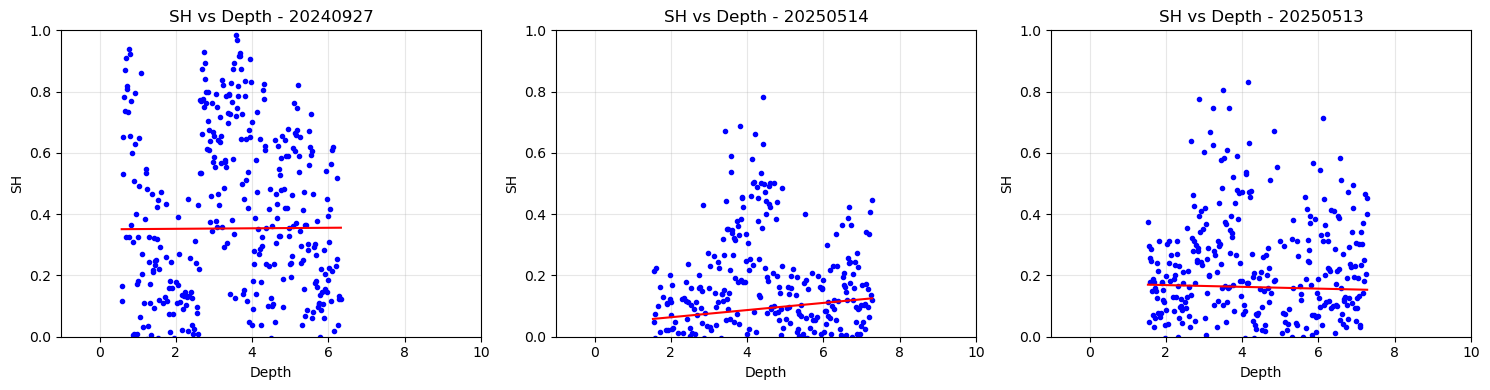

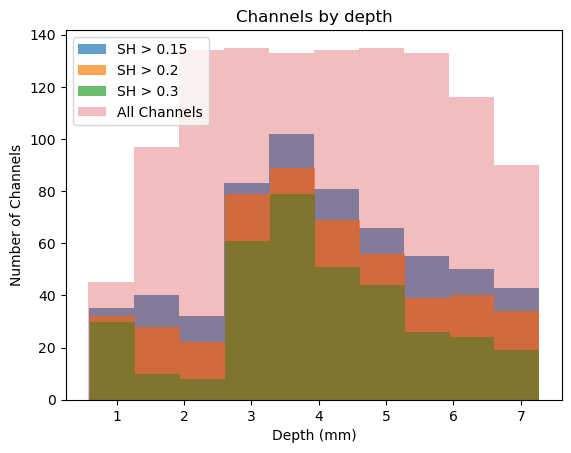

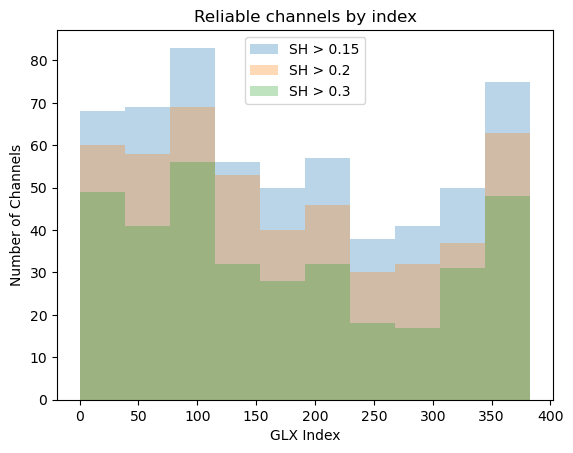

In [276]:
# Plot sh vs depth, reliable depths
date_to_depth = {}
for date in dates:
    df = site_coords[site_coords['date']==date].copy().sort_values(by='ch_idx_glx')
    assert df.shape[0]==384
    date_to_depth[date] = np.array(df['depth'].values)

def plot_sh_vs_depth(date_to_sh, date_to_depth):
    """
    Create separate plots for each date showing sh as a function of depth
    """
    # Get all dates (assuming both dictionaries have the same keys)
    dates = list(date_to_sh.keys())
    
    # Create subplots - adjust the layout based on number of dates
    n_dates = len(dates)
    cols = min(3, n_dates)  # Max 3 columns
    rows = (n_dates + cols - 1) // cols  # Calculate rows needed
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    
    # Handle case where there's only one subplot
    if n_dates == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes if n_dates > 1 else [axes]
    else:
        axes = axes.flatten()
    
    # Plot each date
    for i, date in enumerate(dates):
        ax = axes[i]
        sh_values = date_to_sh[date]
        depth_values = date_to_depth[date]
        ax.set_xlim(-1, 10)
        ax.set_ylim(0, 1)
        ax.plot(depth_values, sh_values, 'bo', markersize=3)
        ax.plot(np.unique(depth_values), np.poly1d(np.polyfit(depth_values, sh_values, 1))(np.unique(depth_values)), c='r')
        ax.set_xlabel('Depth')
        ax.set_ylabel('SH')
        ax.set_title(f'SH vs Depth - {date}')
        ax.grid(True, alpha=0.3)
    
    # Hide any unused subplots
    for i in range(n_dates, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()

plot_sh_vs_depth(date_to_sh, date_to_depth)
plt.savefig(os.path.join(plot_dir_path, 'sh_vs_depth.png'))
plt.show()

date_to_reliable_depths = {}
for limit in sh_limits:
    date_dict = {}
    date_dict = sh_limit_to_date_to_ch[limit]
    for date, depths in date_to_depth.items():
        date_to_reliable_depths[date] = depths[date_dict[date]]
    reliable_depths = list(np.concatenate(list(date_to_reliable_depths.values())))
    plt.hist(reliable_depths, alpha=.7, label=f'SH > {limit}')
depths = list(np.concatenate(list(date_to_depth.values())))
plt.hist(depths, alpha=.3, label='All Channels')
plt.legend()
plt.title(f'Channels by depth')
plt.xlabel('Depth (mm)')
plt.ylabel(f'Number of Channels')
plt.savefig(os.path.join(plot_dir_path, 'ch_vs_depth.png'))
plt.show()

x = []

for limit in sh_limits:
    date_dict = {}
    date_dict = sh_limit_to_date_to_ch[limit]
    ch_idx = list(np.concatenate(list(date_dict.values())))
    plt.hist(ch_idx, alpha=0.3, label = f'SH > {limit}')
plt.title(f'Reliable channels by index')
plt.xlabel('GLX Index')
plt.legend()
plt.ylabel(f'Number of Channels')
plt.savefig(os.path.join(plot_dir_path, 'ch_vs_glx.png'))
plt.show()

In [172]:
# Get decoding score:
print(f'Calculating {dec_column} decoding scores...')

def decoding_score(neural, labels, folds=10):
    unique_img_count = np.unique(labels).shape[0]
    chance = 1/unique_img_count
    scores = np.zeros(folds)
    
    for fold in range(folds):
        neural_train, neural_test, labels_train, labels_test = train_test_split(
            neural, labels, test_size=0.8, stratify=labels
        )
        model = LinearRegression()
        model.fit(neural_train, labels_train)
        labels_pred = model.predict(neural_test)
        labels_final = np.round(labels_pred).astype(int)
        scores[fold] = accuracy_score(labels_test, labels_final)
    avg_score = np.mean(scores)/chance
    return avg_score

date_to_decode = {}
for date in dates:
    date_df = final_df[final_df['date']==date]
    if date_to_reliable_ch[date].size < dec_min_ch:
        print(f'{date} has < {dec_min_ch} reliable channels')
        continue
    neural = np.stack(date_df['psth'].values).mean(axis=2)[:, date_to_reliable_ch[date]]
    labels = LabelEncoder().fit_transform(list(date_df[dec_column]))
    dec_score = decoding_score(neural, labels, folds=dec_folds)
    print(f'{date}: {dec_score:.4f} decode score')
    date_to_decode[date] = dec_score

avg_dec_score = sum(date_to_decode.values())/len(date_to_decode.values())

if avg_dec_score > 0:
    print(f'Average {dec_column} decoding score: {avg_dec_score:.4f}')
else:
    print(f'No dates have >= {dec_min_ch} reliable channels')

Calculating img_full_path decoding scores...
20240927: 1.3268 decode score
20250513: 1.3396 decode score
20250514: 1.2794 decode score
Average img_full_path decoding score: 1.3153


In [173]:
# Get site coordinate info
site_coords_list = []

def get_site_coords_df(monkey, date):
    base_data_path = '/mnt/smb/locker/issa-locker/Data'
    # get zero coords + imro table
    zero_coords = get_coords_sess(base_data_path, monkey, date)
    glx_meta_path = get_sess_metadata_path(base_data_path, monkey, date)
    imro_tbl = extract_imro_table(glx_meta_path)
    
    # Fix dfs, get ch_meta_df
    zero_coords['monkey'] = monkey
    zero_coords['date'] = date
    imro_tbl['monkey'] = monkey
    imro_tbl['date'] = date
    imro_tbl['ch_idx_glx'] = imro_tbl.index
    return chs_meta_2_site_coords(zero_coords, imro_tbl)

start = time.time()

for monkey, monkey_dates in monkey_to_dates.items():
    for date in monkey_dates:
        print(date)
        site_coords_list.append(get_site_coords_df(monkey, date))
    
site_coords = pd.concat(site_coords_list, ignore_index=True)

# Get hole + penetration info for all dates
pen_info_df = final_df[['monkey', 'date', 'source_path']].drop_duplicates(subset=['source_path'])
hole_pattern = r'(H\d{2})'
pen_pattern = r'(P\d{2})'
pen_info_df['hole'] = pen_info_df['source_path'].str.extract(hole_pattern)
pen_info_df['pen_id'] = pen_info_df['source_path'].str.extract(pen_pattern)

# add hole + pen info to site coords
site_coords = site_coords.merge(pen_info_df, on=['monkey', 'date'])

end = time.time()
runtime = end-start
process = 'Site coordinate info'
process_to_runtime[process] = runtime
print(f'Runtime: {runtime:.4f}s')

20240927
/mnt/smb/locker/issa-locker/Data/West


/mnt/smb/locker/issa-locker/users/Dan/code/data_analysis_tools_mkTurk/utils_meta.py:119: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  zero_coord_series = pd.Series()


/mnt/smb/locker/issa-locker/Data/West
20250514
/mnt/smb/locker/issa-locker/Data/Bourgeois


/mnt/smb/locker/issa-locker/users/Dan/code/data_analysis_tools_mkTurk/utils_meta.py:119: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  zero_coord_series = pd.Series()


/mnt/smb/locker/issa-locker/Data/Bourgeois
20250513
/mnt/smb/locker/issa-locker/Data/Bourgeois
/mnt/smb/locker/issa-locker/Data/Bourgeois
Runtime: 8.2445s


/mnt/smb/locker/issa-locker/users/Dan/code/data_analysis_tools_mkTurk/utils_meta.py:119: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  zero_coord_series = pd.Series()


In [174]:
# Create cutoff dataframe
cutoff_df = pd.DataFrame(list(itertools.product(cutoffs, ['IT', 'MT'])), columns=[
    'depth_cutoff',
    'area'
])

cutoff_df = pd.concat((cutoff_df, pd.DataFrame(columns=['channels_used',
                                                        'RDM_shr',
                                                        'RDM_error',
                                                        'date_to_ch',
                                                        'trial_avg_series',
                                                        'single_RDM_shr'])))

In [176]:
# Functions for df --> trial averaged responses --> rdm --> rdm-rdm correlation

# need to rename this
def trial_avg_matrix(df, date_to_ch=None, unusable_dates=[]):
    '''
    Returns 2 dfs with unique images as rows, unique channel*date as column
    date_to_ch: filters channels by date
    '''
    # Create copy restricted to date, img_full_path, and psth
    rdm_filt_df = df[['date','img_full_path', 'psth']].copy()
    
    if unusable_dates:
        rdm_filt_df = rdm_filt_df[~rdm_filt_df['date'].isin(unusable_dates)]
    
    # Create empty df of img x date
    unique_img = rdm_filt_df['img_full_path'].unique()
    unique_date = rdm_filt_df['date'].unique()
    img_date_df = pd.DataFrame(index=unique_img, columns=unique_date)
    img_date_df_half2 = pd.DataFrame(index=unique_img, columns=unique_date)
    
    # List of dates to drop bc empty
    drop_dates = []
    
    # Average across bins, repeats for each image x date combination
    img_date_grouped = rdm_filt_df.groupby(['img_full_path', 'date'])
    
    for img_and_date, group in img_date_grouped:
        # Set image (path) and date as variables
        img, date = img_and_date[0], img_and_date[1]
        
        # Create repeats x ch x bins matrix
        psth_tot = np.stack(group['psth'].values) 
        # Filter channels
        if date_to_ch is not None:
            if date in date_to_ch.keys():
                psth_tot = psth_tot[:, date_to_ch[date], :]
            elif date not in drop_dates:
                drop_dates.append(date)
                continue
        
        # Average across bins, split
        spikes = psth_tot.mean(axis=2)
        
        # Shuffle, split
        np.random.shuffle(spikes)
        spikes_half1, spikes_half2 = np.array_split(spikes, 2, axis=0)
        
        # Assign halves
        img_date_df.loc[img, date] = spikes_half1.mean(axis=0)
        img_date_df_half2.loc[img, date] = spikes_half2.mean(axis=0)
    
    if drop_dates:
        drop_dates_str = ', '.join(drop_dates)
        print(f'{drop_dates_str} not in date_to_ch, will be dropped')
        img_date_df.drop(columns=drop_dates, inplace=True)
        img_date_df_half2.drop(columns=drop_dates, inplace=True)
    
    # Stack date (column) vectors
    img_series = img_date_df.apply(lambda row: np.hstack(row.values), axis=1)
    img_series_2 = img_date_df_half2.apply(lambda row: np.hstack(row.values), axis=1)
    
    return img_series, img_series_2, drop_dates
def rdm(data):
    # Calculate and plot RDM from img x ch/date matrix
    norm_data = zscore(data, axis=1)
    return squareform(pdist(norm_data, metric='correlation'))
def correlate_rdms(rdm1, rdm2):
  
    # Extract off-diagonal elements of each RDM
    ioffdiag = np.triu_indices(rdm1.shape[0], k=1)  # indices of off-diagonal elements
    rdm1_offdiag = rdm1[ioffdiag]
    rdm2_offdiag = rdm2[ioffdiag]
  
    corr_coef = np.corrcoef(rdm1_offdiag, rdm2_offdiag)[0,1]
  
    return corr_coef

In [177]:
# Loop through all area/cutoff combinations and gather data
start = time.time()
for area, bour_cutoff in itertools.product(areas, cutoffs):
    print(f'\nChecking {area} cut off at {bour_cutoff}...')
    
    # Set mask
    cutoff_area_mask = (cutoff_df['depth_cutoff']==bour_cutoff) & (cutoff_df['area']==area)
    # Need row index to use .at when storing dict/series
    row_idx = cutoff_area_mask[cutoff_area_mask].index[0]
    
    if area == 'IT':
        bour_mask = (site_coords['monkey']=='Bourgeois') & (site_coords['depth']<bour_cutoff)
        west_mask = (site_coords['monkey']=='West') & (site_coords['depth']<(bour_cutoff + west_bour_diff))
    elif area == 'MT':
        bour_mask = (site_coords['monkey']=='Bourgeois') & (site_coords['depth']>bour_cutoff)
        west_mask = (site_coords['monkey']=='West') & (site_coords['depth']>(bour_cutoff + west_bour_diff))
    
    # Create IT specific and MT specific dataframes
    area_df = site_coords[bour_mask|west_mask]
    
    # Merge them to get reliable brain area indices
    def ch_overlap_dict(ch_dict, ch_df):
        def ch_df_from_dict(ch_dict):
            df = pd.DataFrame(list(ch_dict.items()), columns=['date', 'ch_idx_glx'])
            return df.explode('ch_idx_glx').reset_index(drop=True)
        inner_df = pd.merge(ch_df, ch_df_from_dict(ch_dict), on=['date', 'ch_idx_glx'], how='inner')
        df_to_int = lambda x: x.astype('int64').values
        inner_dict = inner_df.groupby('date')['ch_idx_glx'].apply(df_to_int).to_dict()
        return inner_dict
    
    # Determine dates to cross reference ashley labels with:
    labeled_dates_used = [date for date in final_df.date.unique() if date in labeled_dates]
    
    # Check IT ranges
    for date in labeled_dates_used:
        area_ch = area_df[area_df.date==date].ch_idx_glx.unique()
        if len(area_ch) > 0:
            print(f'{date} {area} channels: {min(area_ch)} to {max(area_ch)}')
        else:
            print(f'{date} {area} has no channels')
    
    # Get date to reliable channel dictionary, store it
    area_date_to_reliable_ch = ch_overlap_dict(date_to_reliable_ch, area_df)
    for monkey in monkeys:
        ch_count = sum(len(ch_arr) for date, ch_arr in area_date_to_reliable_ch.items() if date in monkey_to_dates[monkey])
        print(f'{monkey} {area} ch: {ch_count}')
    total_ch_count = sum(len(ch_arr) for ch_arr in area_date_to_reliable_ch.values())
    cutoff_df.loc[cutoff_area_mask, 'channels_used'] = total_ch_count
    print(f'Total {area} ch: {total_ch_count}')
    date_to_ch = area_date_to_reliable_ch
        
    # Wrap in list to store
    cutoff_df.at[row_idx, 'date_to_ch'] = date_to_ch
    
    # Get trial averaged values, single RDM SHR
    trial_avg_series, trial_avg_half2, unusable_dates = trial_avg_matrix(final_df, date_to_ch=date_to_ch)
    
    rdm_half1 = rdm(np.vstack(trial_avg_series.values))
    rdm_half2 = rdm(np.vstack(trial_avg_half2.values))
    rdm_shr = correlate_rdms(rdm_half1, rdm_half2)
    
    # Wrap trial_avg_series in list to store
    cutoff_df.at[row_idx, 'trial_avg_series'] = trial_avg_series
    cutoff_df.loc[cutoff_area_mask, 'single_RDM_shr'] = rdm_shr
    
    # Get RDM SHR, error
    start = time.time()
    rdm_shrs = np.zeros(rdm_shr_folds)
    for fold in range(rdm_shr_folds):
        half1, half2, _ = trial_avg_matrix(final_df, date_to_ch=date_to_ch, unusable_dates=unusable_dates)
        rdm_half1 = rdm(np.vstack(half1.values))
        rdm_half2 = rdm(np.vstack(half2.values))
        rdm_shrs[fold] = correlate_rdms(rdm_half1, rdm_half2)
        print(f'Done with fold {fold+1}...')
    rdm_shr_err = np.std(rdm_shrs)
    rdm_avg_shr = np.mean(rdm_shrs)
    
    cutoff_df.loc[cutoff_area_mask, 'RDM_error'] = np.std(rdm_shrs)
    cutoff_df.loc[cutoff_area_mask, 'RDM_shr'] = np.mean(rdm_shrs)
    print(f'Done with {area}, {bour_cutoff}.')

end = time.time()
runtime = end-start
process = 'Full Area RDM SHR'
process_to_runtime[process] = runtime
print(f'Runtime: {runtime:.4f}s')


Checking IT cut off at 2...
West IT ch: 63
Bourgeois IT ch: 20
Total IT ch: 83
Done with fold 1...
Done with fold 2...
Done with fold 3...
Done with fold 4...
Done with fold 5...
Done with fold 6...
Done with fold 7...
Done with fold 8...
Done with fold 9...
Done with fold 10...
Done with IT, 2.

Checking IT cut off at 2.25...
West IT ch: 76
Bourgeois IT ch: 28
Total IT ch: 104
Done with fold 1...
Done with fold 2...
Done with fold 3...
Done with fold 4...
Done with fold 5...
Done with fold 6...
Done with fold 7...
Done with fold 8...
Done with fold 9...
Done with fold 10...
Done with IT, 2.25.

Checking IT cut off at 2.5...
West IT ch: 93
Bourgeois IT ch: 37
Total IT ch: 130
Done with fold 1...
Done with fold 2...
Done with fold 3...
Done with fold 4...
Done with fold 5...
Done with fold 6...
Done with fold 7...
Done with fold 8...
Done with fold 9...
Done with fold 10...
Done with IT, 2.5.

Checking IT cut off at 2.75...
West IT ch: 109
Bourgeois IT ch: 49
Total IT ch: 158
Done with

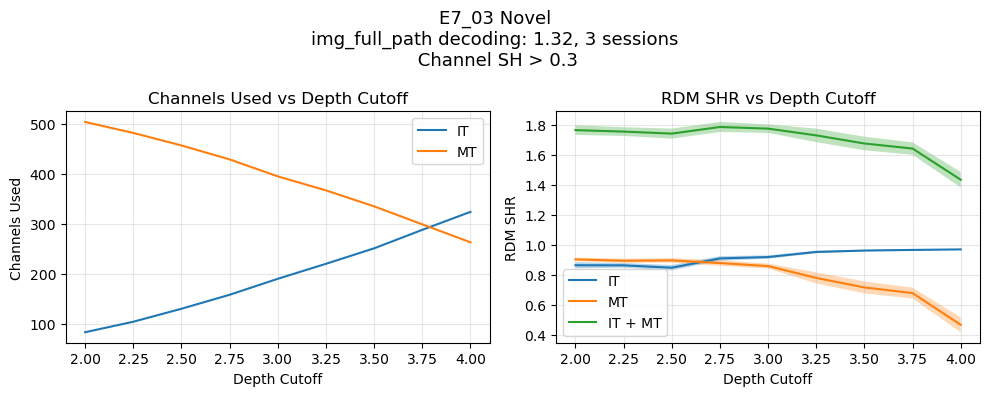

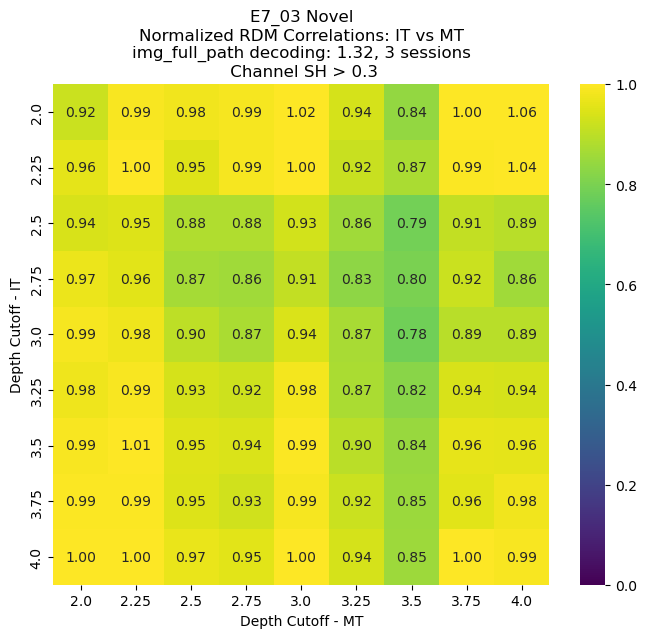

In [183]:
# Plot cutoff - RDM SHR/channels and RDM Corrs !!! NEED TO CHANGE
title = f'{imageset}\n{dec_column} decoding: {avg_dec_score:.2f}, {len(dates)} sessions\n Channel SH > {sh_limit}'

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# First subplot - Channels Used vs Depth Cutoff
for area in cutoff_df['area'].unique():
    df = cutoff_df[cutoff_df['area']==area]
    df = df[['depth_cutoff', 'channels_used']].astype('float')
    ax1.errorbar(df['depth_cutoff'], df['channels_used'], label=area)

# NEED TO INFER BASED ON RANGE
ax1.set_xticks(np.arange(2, 4.25, 0.25))
ax1.set_xlabel('Depth Cutoff')
ax1.set_ylabel('Channels Used')
ax1.set_title('Channels Used vs Depth Cutoff')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Second subplot - RDM SHR vs Depth Cutoff
it_data = None
mt_data = None

for area in cutoff_df['area'].unique():
    df = cutoff_df[cutoff_df['area']==area]
    df = df[['depth_cutoff', 'RDM_shr', 'RDM_error', 'channels_used']].astype('float')
    
    # Store IT and MT data for sum calculation
    if area == 'IT':
        it_data = df.copy()
    elif area == 'MT':
        mt_data = df.copy()
    
    # Plot line with error bars
    ax2.errorbar(df['depth_cutoff'], df['RDM_shr'], label=area)
    
    # Add error band
    ax2.fill_between(df['depth_cutoff'], 
                     df['RDM_shr'] - df['RDM_error'], 
                     df['RDM_shr'] + df['RDM_error'], 
                     alpha=0.3)

# Add IT + MT sum line
if it_data is not None and mt_data is not None and plot_sum is True:
    # Merge on depth_cutoff to align data points
    merged = it_data.merge(mt_data, on='depth_cutoff', suffixes=('_it', '_mt'))
    
    # Calculate sum of RDM_shr and RDM_error
    sum_shr = merged['RDM_shr_it'] + merged['RDM_shr_mt']
    sum_error = merged['RDM_error_it'] + merged['RDM_error_mt']
    
    # Plot sum line
    ax2.errorbar(merged['depth_cutoff'], sum_shr, label='IT + MT')
    
    # Add error band for sum
    ax2.fill_between(merged['depth_cutoff'], 
                     sum_shr - sum_error, 
                     sum_shr + sum_error, 
                     alpha=0.3)

ax2.set_xticks(np.arange(2, 4.25, 0.25))
ax2.set_xlabel('Depth Cutoff')
ax2.set_ylabel('RDM SHR')
ax2.set_title('RDM SHR vs Depth Cutoff')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add main title above both subplots
fig.suptitle(title, fontsize=13, y=.98)

# Adjust layout and display
plt.tight_layout()

fig_folder_path = f'{locker_path}/users/Parsa/marmoset_figures/MT_IT_cutoff_curves/{imageset}_{sh_limit}chSHR'

if not os.path.exists(fig_folder_path):
    os.makedirs(fig_folder_path)

plt.savefig(os.path.join(plot_dir_path, 'cutoff_plot.png'))

plt.show()

# Get RDM correlations
df = cutoff_df
# Get the two unique areas
areas = df['area'].unique()
assert len(areas) == 2, "This approach assumes exactly 2 areas"

area1, area2 = areas
depth_cutoffs = sorted(df['depth_cutoff'].unique())

# Create subsets for each area
df_area1 = df[df['area'] == area1].set_index('depth_cutoff')
df_area2 = df[df['area'] == area2].set_index('depth_cutoff')

# Create the heatmap matrix
heatmap_data = np.zeros((len(depth_cutoffs), len(depth_cutoffs)))

# Fill the matrix: rows = area1, columns = area2
for i, cutoff1 in enumerate(depth_cutoffs):
    for j, cutoff2 in enumerate(depth_cutoffs):
        series1 = df_area1.loc[cutoff1, 'trial_avg_series']
        series2 = df_area2.loc[cutoff2, 'trial_avg_series']
        shr1 = df_area1.loc[cutoff1, 'RDM_shr']
        shr2 = df_area2.loc[cutoff2, 'RDM_shr']
        rdm1 = rdm(np.vstack(series1.values).astype(np.float32))
        rdm2 = rdm(np.vstack(series2.values).astype(np.float32))
        heatmap_data[i, j] = correlate_rdms(rdm1, rdm2)/math.sqrt(shr1*shr2)

# Create the heatmap
plt.figure(figsize=(8, 6.5))
sns.heatmap(heatmap_data, 
            xticklabels=depth_cutoffs, 
            yticklabels=depth_cutoffs,
            vmin=0,
            vmax=1,
            annot=True, 
            fmt='.2f',
            cmap='viridis')
plt.xlabel(f'Depth Cutoff - {area2}')
plt.ylabel(f'Depth Cutoff - {area1}')
title = f'{imageset}\nNormalized RDM Correlations: {area1} vs {area2}\n{dec_column} decoding: {avg_dec_score:.2f}, {len(dates)} sessions\n Channel SH > {sh_limit}'
plt.title(title)

plt.savefig(os.path.join(plot_dir_path, 'RDMcorrs.png'))

plt.show()

In [185]:
# Add no cutoff/both areas data ('All', uses all reliable channels)
if not (cutoff_df['area']=='All').any():
    cutoff_df = pd.concat([cutoff_df, pd.DataFrame({'area': ['All']})], ignore_index=True)

# Set mask
cutoff_area_mask = cutoff_df['area']=='All'
# Need row index to use .at when storing dict/series
row_idx = cutoff_area_mask[cutoff_area_mask].index[0]
print(row_idx)

# Get trial averaged values, single RDM SHR
date_to_ch = date_to_reliable_ch
total_ch_count = sum(len(ch_arr) for ch_arr in date_to_reliable_ch.values())
cutoff_df.loc[cutoff_area_mask, 'channels_used'] = total_ch_count
cutoff_df.at[row_idx, 'date_to_ch'] = date_to_ch

trial_avg_series, trial_avg_half2, unusable_dates = trial_avg_matrix(final_df, date_to_ch=date_to_ch)

rdm_half1 = rdm(np.vstack(trial_avg_series.values))
rdm_half2 = rdm(np.vstack(trial_avg_half2.values))
rdm_shr = correlate_rdms(rdm_half1, rdm_half2)

# Wrap trial_avg_series in list to store
cutoff_df.at[row_idx, 'trial_avg_series'] = trial_avg_series
cutoff_df.loc[cutoff_area_mask, 'single_RDM_shr'] = rdm_shr

# Get RDM SHR, error
start = time.time()
rdm_shrs = np.zeros(rdm_shr_folds)
for fold in range(rdm_shr_folds):
    half1, half2, _ = trial_avg_matrix(final_df, date_to_ch=date_to_ch, unusable_dates=unusable_dates)
    rdm_half1 = rdm(np.vstack(half1.values))
    rdm_half2 = rdm(np.vstack(half2.values))
    rdm_shrs[fold] = correlate_rdms(rdm_half1, rdm_half2)
    print(f'Done with fold {fold+1}...')
rdm_shr_err = np.std(rdm_shrs)
rdm_avg_shr = np.mean(rdm_shrs)

cutoff_df.loc[cutoff_area_mask, 'RDM_error'] = np.std(rdm_shrs)
cutoff_df.loc[cutoff_area_mask, 'RDM_shr'] = np.mean(rdm_shrs)
print(f'Done with all ch.')

end = time.time()
runtime = end-start
process = 'RDM SHR'
process_to_runtime[process] = runtime
print(f'Runtime: {runtime:.4f}s')

18
Done with fold 1...
Done with fold 2...
Done with fold 3...
Done with fold 4...
Done with fold 5...
Done with fold 6...
Done with fold 7...
Done with fold 8...
Done with fold 9...
Done with fold 10...
Done with all ch.
Runtime: 1.8903s


In [18]:
# Set image paths, transform
img_paths = final_df.img_full_path.unique()
print(f'Images being used: {img_paths.shape[0]}')

transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])

NameError: name 'model_names' is not defined

In [41]:
# Lock model, process image function
model_lock = Lock()

def process_image(path):
    # Load and preprocess image
    img = Image.open(path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    with model_lock:
        activations.clear()
        _ = model(img_tensor)
        result = activations.copy()
    
    return path, result

def process_image_latent(path):
    # Load and preprocess image
    img = Image.open(path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)
    batch_size = img_tensor.size(0)  # assuming img_tensor is your input
    dummies = torch.zeros((batch_size, model.side_info_dim, 1), device=device)
    
    with model_lock:
        activations.clear()
        _ = model(img_tensor, dummies)
        result = activations.copy()
    
    return path, result

In [47]:
# Run models, get activations, RDM dicts
start = time.time()

model_to_activations = {}
model_to_rdm_dict = {}

def get_activation(name, sample=False):
    def hook(model, input, output):
        # Flatten the activation and convert to numpy
        if sample is True: # Assumes have already create layer_to_idx
            activations[name] = output.detach().flatten()[layer_to_idx[name]].cpu().numpy()
        else:
            activations[name] = output.detach().cpu().numpy().flatten()
    return hook

for model_name in model_names:
    # Variable that indicates needing dummies for latent prediction
    latent = False
    
    # Load model
    if model_name in list(SBarlow_to_ckpt.keys()):
        model = BarlowTwinsLightningModule.load_from_checkpoint(SBarlow_to_ckpt[model_name]).model
    elif model_name in list(SObj_to_ckpt.keys()):
        model = ObjectClassificationLightningModule.load_from_checkpoint(SObj_to_ckpt[model_name]).model
    elif model_name in list(SLatent_to_ckpt.keys()):
        model = LatentPredictionLightningModule.load_from_checkpoint(
            SLatent_to_ckpt[model_name],
            strict=False).model
        latent = True
    elif model_name in list(SL_to_model.keys()):
        model = load_SL_model(SL_to_model[model_name])
    elif model_name == 'untrained_resnet50':
        model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights=None)
    elif model_name == 'resnet50':
        model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights=ResNet50_Weights.DEFAULT)
    elif model_name == 'barlow':
        model = torch.hub.load('facebookresearch/barlowtwins:main', 'resnet50')
    elif model_name == 'resnet34':
        model = torchvision.models.resnet34(pretrained=True)
    elif model_name == 'resnet18':
        model = torchvision.models.resnet18(pretrained=True) 
    
    # Set device, set model to eval
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    
    # Df to store all results
    model_activations = pd.DataFrame(index=img_paths, columns=layer_names)
    
    # Set up hooks + activations to get layer_subset_idx
    if sample_layers is True:
        activations = {}
        hooks = []
        # Pass dummy tensor without sampling
        for name, layer in model.named_modules():
            if name in layer_names:
                hook = layer.register_forward_hook(get_activation(name, sample=False))
                hooks.append(hook)
        layer_to_idx = {}
        dummy_input = torch.randn(1, 3, 224, 224).to(device)
        if latent:
            dummies = torch.zeros(1, model.side_info_dim, 1).to(device) # assuming batch size 1
            _ = model(dummy_input, dummies)
        else:
            _ = model(dummy_input)
        for name, vect in activations.items():
            features_subset = max(layer_subset_size, int(len(vect)*layer_subset_portion))
            print(f'{name}: chose {features_subset} of {len(vect)} features')
            layer_to_idx[name] = np.random.choice(len(vect), size=features_subset, replace=False)
        # Remove hooks
        for hook in hooks:
            hook.remove()
    
    # Set up hooks for all layers
    activations = {}
    hooks = []
    for name, layer in model.named_modules():
        if name in layer_names:
            hook = layer.register_forward_hook(get_activation(name, sample=sample_layers))
            hooks.append(hook)

    # Process each image
    with torch.no_grad():
        if latent:
            with ThreadPoolExecutor(max_workers=cores*4) as executor:
                results = list(executor.map(process_image_latent, img_paths))
        else:    
            with ThreadPoolExecutor(max_workers=cores*4) as executor:
                results = list(executor.map(process_image, img_paths))
        for hook in hooks:
            hook.remove()
        # Store results
        for path, activation_data in results:
            model_activations.loc[path] = activation_data
    print('Done processing images...')
    
    # Create DataFrame, save activations
    model_to_activations[model_name] = model_activations
    print(f'Done with {model_name}')

end = time.time()
runtime = end-start
process = 'Model activations'
process_to_runtime[process] = runtime
print(f'Runtime: {runtime:.4f}s')

Using cache found in /home/pt2636/.cache/torch/hub/pytorch_vision_v0.10.0


layer1.0.conv1: chose 20070 of 200704 features
layer2.0.conv1: chose 40140 of 401408 features
layer3.0.conv1: chose 20070 of 200704 features
layer4.1.conv2: chose 2508 of 25088 features
avgpool: chose 2048 of 2048 features
Done processing images...
Done with untrained_resnet50


Using cache found in /home/pt2636/.cache/torch/hub/facebookresearch_barlowtwins_main
/home/pt2636/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pt2636/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


layer1.0.conv1: chose 20070 of 200704 features
layer2.0.conv1: chose 40140 of 401408 features
layer3.0.conv1: chose 20070 of 200704 features
layer4.1.conv2: chose 2508 of 25088 features
avgpool: chose 2048 of 2048 features
Done processing images...
Done with barlow
layer1.0.conv1: chose 20070 of 200704 features
layer2.0.conv1: chose 40140 of 401408 features
layer3.0.conv1: chose 20070 of 200704 features
layer4.1.conv2: chose 2508 of 25088 features
avgpool: chose 2048 of 2048 features
Done processing images...
Done with objectome_bt_100
layer1.0.conv1: chose 20070 of 200704 features
layer2.0.conv1: chose 40140 of 401408 features
layer3.0.conv1: chose 20070 of 200704 features
layer4.1.conv2: chose 2508 of 25088 features
avgpool: chose 2048 of 2048 features
Done processing images...
Done with objectome_lp_ph_ait_good_params_100
layer1.0.conv1: chose 20070 of 200704 features
layer2.0.conv1: chose 40140 of 401408 features
layer3.0.conv1: chose 20070 of 200704 features
layer4.1.conv2: chose 

Using cache found in /home/pt2636/.cache/torch/hub/pytorch_vision_v0.10.0


layer1.0.conv1: chose 20070 of 200704 features
layer2.0.conv1: chose 40140 of 401408 features
layer3.0.conv1: chose 20070 of 200704 features
layer4.1.conv2: chose 2508 of 25088 features
avgpool: chose 2048 of 2048 features
Done processing images...
Done with resnet50
Runtime: 186.6715s


In [49]:
# functions for saving + loading activations (note need to loop across model_names)
def save_activations(model_name, imageset, directory, model_to_activations):
    path = os.path.join(directory, f'{imageset}_{model_name}.h5')
    model_to_activations[model_name].to_hdf(path, key='data', mode='w')

def load_activations(model_name, imageset, directory):
    path = os.path.join(directory, f'{imageset}_{model_name}.h5')
    return pd.read_hdf(path, key='data')

# Save model activations
if save_activations is True:
    for model_name in model_names:
        save_activations(model_name, imageset, activations_dir, model_to_activations)
        print(f'Saved {model_name}')

In [68]:
# Monitor resources
# Create a stop event
stop_event = threading.Event()

def monitor_resources():
    """Monitor CPU and I/O usage"""
    while not stop_event.is_set():  # Check if we should stop
        cpu_percent = psutil.cpu_percent(interval=1)
        io_counters = psutil.disk_io_counters()
        memory = psutil.virtual_memory()
        
        print(f"CPU: {cpu_percent}% | Memory: {memory.percent}% | "
              f"Disk Read: {io_counters.read_bytes/1024/1024:.1f}MB | "
              f"Disk Write: {io_counters.write_bytes/1024/1024:.1f}MB")
        
        # Use wait instead of sleep so we can be interrupted
        stop_event.wait(2)  # Wait 2 seconds or until stop_event is set

# Start monitoring
monitor_thread = threading.Thread(target=monitor_resources, daemon=True)
monitor_thread.start()

# Stop monitoring
stop_event.set()
monitor_thread.join()  # Wait for thread to finish
print("Monitoring stopped")
# Set area, depth cutoff
area = 'All'
depth_cutoff = None

CPU: 0.1% | Memory: 12.7% | Disk Read: 3708792.8MB | Disk Write: 2514924.7MB
Monitoring stopped


In [ ]:
# Add neural data, calculate RDMs
start = time.time()

shr_dict = {}
error_dict = {}
area_to_rdm = {}

for area, depth_cutoff in area_cutoff_dict.items():
    if area=='All':
        cutoff_area_mask = cutoff_df['area']==area
    else:
        cutoff_area_mask = (cutoff_df['depth_cutoff']==depth_cutoff) & (cutoff_df['area']==area)
    row_idx = cutoff_area_mask[cutoff_area_mask].index[0]
    neural = cutoff_df.at[row_idx, 'trial_avg_series']
    rdm_shr = cutoff_df.at[row_idx, 'single_RDM_shr']
    shr_dict[area] = rdm_shr
    rdm_shr_err = cutoff_df.at[row_idx, 'RDM_error']
    error_dict[area] = rdm_shr_err
    print(f'{area} {cutoff} SHR: {rdm_shr}, Error: {rdm_shr_err}')
    area_to_rdm[area] = rdm(np.vstack(neural.values).astype(np.float32))
    if update_neural is True:
        for model_name in model_names:
            # Create + save rdm to rdm_dict
            responses = model_to_activations[model_name]
            responses[area] = neural
            resp_dict = {}
            for col in responses.columns:
                resp_dict[col] = np.vstack(responses[col].values).astype(np.float32)
            rdm_dict = {label: rdm(resp) for label, resp in resp_dict.items()}
            model_to_rdm_dict[model_name] = rdm_dict
            print(f'Done with {model_name}')
            
end = time.time()
runtime = end-start
process = 'Calculate RDMs'
process_to_runtime[process] = runtime
print(f'Runtime: {runtime:.4f}s')

In [132]:
# Determine whether to normalize by SHR or not
if len(area_to_rdm) > 1:
    extras = {}
    if normalize_by_shr:
        for (area1, rdm1), (area2, rdm2) in itertools.combinations(area_to_rdm.items(), 2):
            new_key = f'Norm {area1}-{area2} Corr'  # or however you want to combine keys
            extras[new_key] = correlate_rdms(rdm1, rdm2)/math.sqrt(shr_dict[area1]*shr_dict[area2])
    else:
        for (area1, rdm1), (area2, rdm2) in itertools.combinations(area_to_rdm.items(), 2):
            new_key = f'{area1}-{area2} Corr'  # or however you want to combine keys
            extras[new_key] = correlate_rdms(rdm1, rdm2)

extras_strs = [f'{key}: {value}' for key, value in extras.items()]
print('\n'.join(extras_strs))

{'Norm IT-MT Corr': 0.37550638468047554}

In [142]:
# Set title for models, monkeys
models_title = ', '.join(model_names)

if set(all_seojin).issubset(model_names):
    models_title = 'All Seojin'
if set(all_sreyas).issubset(model_names):
    models_title = 'All Sreyas'

standard_models = ['resnet50',
 'untrained_resnet50',
 'barlow',
 'objectome_bt_100',
 'objectome_lp_ph_ait_good_params_100',
 'objectome_scene_class',
 'SSRN50_FT_4id_7em',]

if set(model_names)==set(standard_models):
    models_title = 'Standard'
if set(monkeys) == {'West', 'Bourgeois'}:
    monkeys_title = ''
else:
    monkeys_title = f'{monkeys[0]}_'

print(monkeys_title)
print(models_title)

# Choose layer, plot best fits
plot_layers = layer_names


Standard


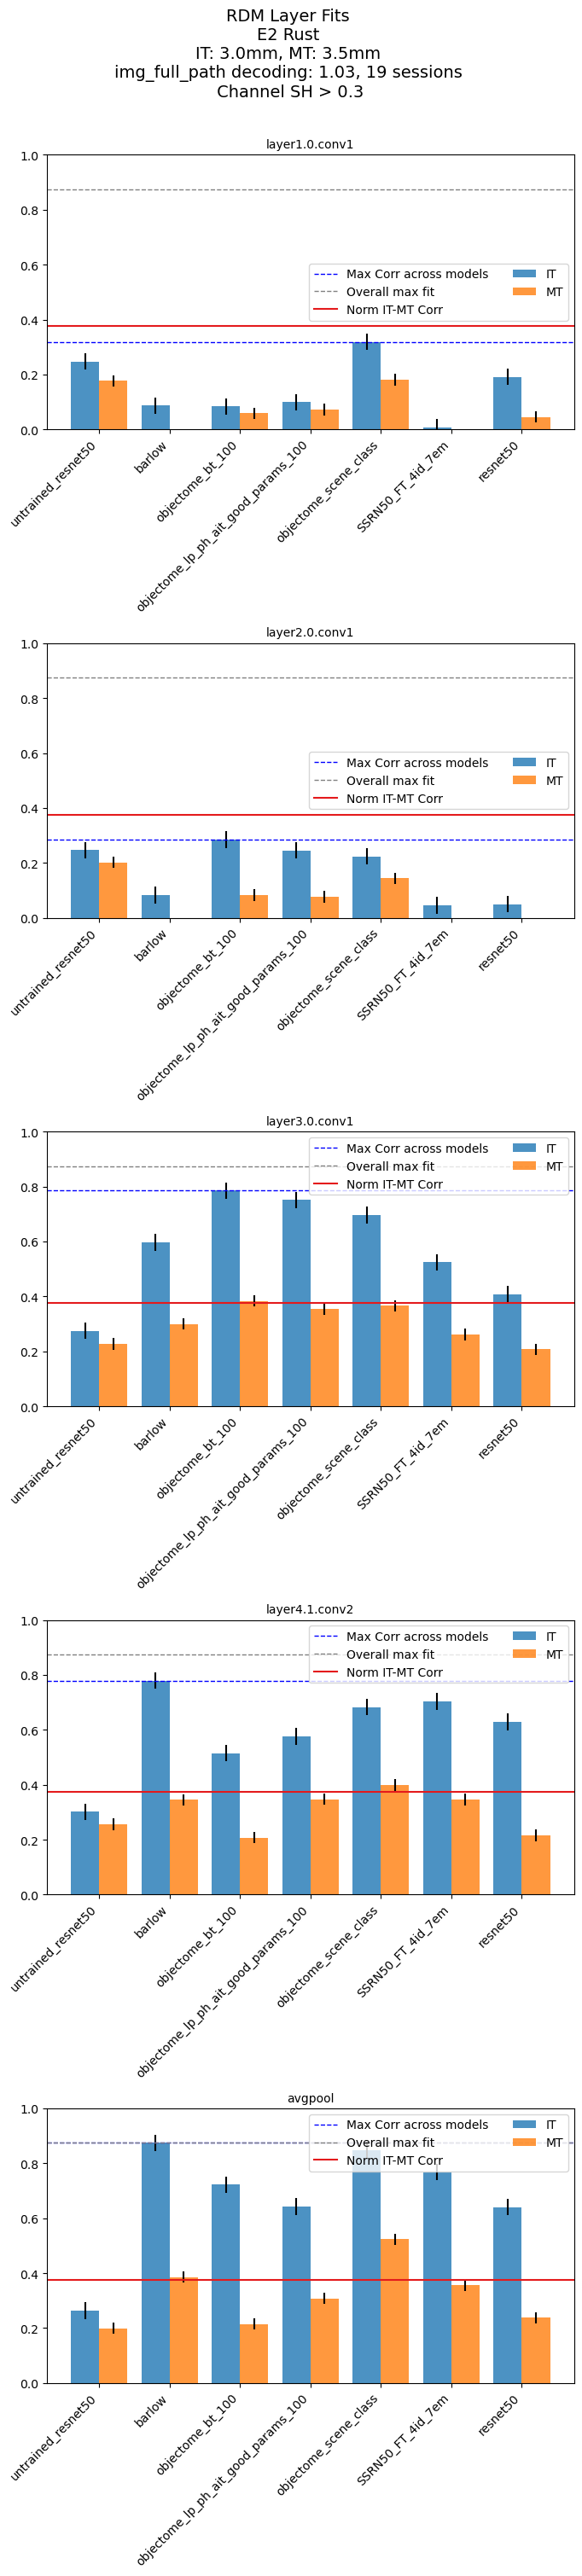

In [164]:
# Plot layer-wise fits (CHANGE SAVE PATH)
def plot_layers_fit(rdm_nested_dict, shr, error, layers, title, neural_keys=['Neural'], normalize=False, extras=None):
    '''
    rdm_nested_dict: nested dictionary that goes model:layer:RDM
    shr: split-halves reliability (of RDM) - can be single value or dict/list matching neural_keys
    error: error values - can be single value or dict/list matching neural_keys
    layers: list of layers to use RDMs
    neural_keys: list of keys to pop from each model dict (default: ['Neural'])
    extras: dict of values to be added to each ax (layer)
    '''
    n_rows = len(layers)
    n_cols = len(rdm_nested_dict)
    fig, axs = plt.subplots(n_rows, 1, figsize=(n_cols, 6 * n_rows))
    
    fig.suptitle(title, fontsize=14, y=1.005)
    
    # Handle single row case
    if n_rows == 1:
        axs = [axs]
    
    # Handle shr and error inputs - can be single values, dicts, or lists
    def get_value_for_key(param, key, default=None):
        if isinstance(param, dict):
            return param.get(key, default)
        elif isinstance(param, (list, tuple)):
            key_index = neural_keys.index(key) if key in neural_keys else 0
            return param[key_index] if key_index < len(param) else default
        else:
            return param
    
    best_fit = []
    for row, layer in enumerate(layers):
        model_to_fit = {key: {} for key in neural_keys}  # Initialize dict for each neural key
        
        for (model, model_dict) in rdm_nested_dict.items():
            # Compute correlations for this row
            rdm_dict = model_dict.copy()
            
            # Pop all neural keys and compute correlations
            for neural_key in neural_keys:
                if neural_key in rdm_dict:
                    rdm_neural = rdm_dict.pop(neural_key)
                    model_to_fit[neural_key][model] = correlate_rdms(rdm_neural, rdm_dict[layer])
        
        # Find best fit across all neural keys
        all_values = []
        
        # Create grouped bar plot
        models = list(rdm_nested_dict.keys())
        x = np.arange(len(models))
        width = 0.8 / len(neural_keys)  # Width of bars
        
        for i, neural_key in enumerate(neural_keys):
            values = [model_to_fit[neural_key].get(model, 0) for model in models]
            offset = (i - len(neural_keys)/2 + 0.5) * width
            if normalize:
                key_shr = get_value_for_key(avg_shr, neural_key, 1)  # default to 1 to avoid division by zero
                # normalize values
                values = [v / key_shr for v in values]
                # add values to list (used for calculating max)
                all_values.extend(values)
                key_error = get_value_for_key(error, neural_key, 0) / key_shr
                bars = axs[row].bar(x + offset, values, width, label=neural_key, 
                            yerr=key_error, ecolor='black', alpha=0.8)                
            else:
                # add values to list (used for calculating max)
                all_values.extend(values)
                # Get error
                key_error = get_value_for_key(error, neural_key, 0)
                
                bars = axs[row].bar(x + offset, values, width, label=neural_key, 
                            yerr=key_error, ecolor='black', alpha=0.8)
                bar_color = bars[0].get_facecolor()  # Get color from the first bar in this group
                key_shr = get_value_for_key(shr, neural_key, None)
                if key_shr is not None:
                    axs[row].axhline(y=key_shr, color=bar_color, linestyle='--', linewidth=2, 
                                   alpha=0.7, label=f'SHR ({neural_key})' if len(neural_keys) > 1 else 'Split-half reliability')
        
        axs[row].axhline(y=max(all_values), color='blue', linestyle='--', linewidth=1, label='Max Corr across models')
        
        axs[row].set_xticks(x)
        axs[row].set_xticklabels(models, rotation=45, ha='right')
        axs[row].set_title(f'{layer}', fontsize=10)
        
        best_fit.append(max(all_values))
    # Add overall max fit line, along with legend + extra lines
    max_fit = max(best_fit)
    for ax in axs:
        ax.axhline(y=max_fit, color='grey', linestyle='--', linewidth=1, label='Overall max fit')
        if extras is not None:
            colors = plt.cm.Set1(np.linspace(0, 1, len(extras)))  # or 'Dark2', 'Accent'
            for i, (key, value) in enumerate(extras.items()):
                ax.axhline(y=value, color=colors[i], label=key)
        ax.legend(ncol=2)
        ax.set_ylim(0, 1)

area_cutoff_str = ', '.join([f'{area}: {cutoff}mm' for area, cutoff in area_cutoff_dict.items()])        
        
params_title = f'{imageset}\n{area_cutoff_str}\n{dec_column} decoding: {avg_dec_score:.2f}, {len(dates)} sessions\n Channel SH > {sh_limit}'
title = f'RDM Layer Fits\n{params_title}'

plot_layers_fit(model_to_rdm_dict, 
                shr_dict, 
                error_dict, 
                plot_layers,
                title,
                neural_keys=list(area_cutoff_dict.keys()),
                normalize=normalize_by_shr,
                extras=extras)

plt.tight_layout()

imageset_folder_path = f'{locker_path}/users/Parsa/marmoset_figures/{imageset}'

if not os.path.exists(imageset_folder_path):
    os.makedirs(imageset_folder_path)

plt.savefig(os.path.join(plot_dir_path, 'layer_RDM_corrs.png'), bbox_inches='tight')

In [105]:
# Plot single-model correlations
def plot_nested_correlations(rdm_nested_dict, shr, error, layers, title, neural_keys=['Neural']):
    """
    Plot correlations for nested dictionary with row suptitles.
    
    rdm_nested_dict: nested dictionary
    shr: split-halves reliability - can be single value or dict/list matching neural_keys
    error: error values - can be single value or dict/list matching neural_keys
    layers: list of model layers that should be plotted
    title: plot title
    neural_keys: list of keys to pop from each inner dict (default: ['Neural'])
    """
    
    # Handle shr and error inputs - can be single values, dicts, or lists
    def get_value_for_key(param, key, default=None):
        if isinstance(param, dict):
            return param.get(key, default)
        elif isinstance(param, (list, tuple)):
            key_index = neural_keys.index(key) if key in neural_keys else 0
            return param[key_index] if key_index < len(param) else default
        else:
            return param
    
    n_rows = len(rdm_nested_dict)
    
    fig, axs = plt.subplots(n_rows, 1, figsize=(7, 3.5 * n_rows))
    fig.text(1.05, 0.5, title, rotation=-90, va='center', fontsize=12, fontweight='bold')
    
    # Handle single row case
    if n_rows == 1:
        axs = [axs]
    
    for row, (row_key, inner_dict) in enumerate(rdm_nested_dict.items()):
        # Compute correlations for this row
        rdm_model = inner_dict.copy()
        
        # Store correlations for each neural key
        neural_correlations = {}
        
        # Pop all neural keys and compute correlations
        for neural_key in neural_keys:
            if neural_key in rdm_model:
                rdm_model_copy = rdm_model.copy()  # Make a fresh copy for each neural key
                rdm_neural = rdm_model_copy.pop(neural_key)
                neural_correlations[neural_key] = {label: correlate_rdms(rdm_neural, rdm) 
                                                 for label, rdm in rdm_model_copy.items()}
        
        # Get all model labels (should be same across neural keys)
        model_labels = layers
        
        # Create grouped bar plot
        x = np.arange(len(model_labels))
        width = 0.8 / len(neural_keys)  # Width of bars
        
        for i, neural_key in enumerate(neural_keys):
            if neural_key in neural_correlations:
                values = [neural_correlations[neural_key][label] for label in model_labels]
                offset = (i - len(neural_keys)/2 + 0.5) * width
                
                # Get error for this specific key
                key_error = get_value_for_key(error, neural_key, 0)
                
                bars = axs[row].bar(x + offset, values, width, label=neural_key, 
                                   yerr=key_error, ecolor='black', alpha=0.8)
                
                # Add SHR line with matching color
                bar_color = bars[0].get_facecolor()
                key_shr = get_value_for_key(shr, neural_key, None)
                if key_shr is not None:
                    axs[row].axhline(y=key_shr, color=bar_color, linestyle='--', linewidth=2, 
                                   alpha=0.7, label=f'SHR ({neural_key})' if len(neural_keys) > 1 else 'Split-half reliability')
        
        axs[row].set_ylim(0, 1)
        axs[row].set_xticks(x)
        axs[row].set_xticklabels(model_labels, rotation=45, ha='right')
        axs[row].set_title(f'{row_key} ~ Neural RDM Corrs', fontsize=10)
        axs[row].legend()
    
    plt.tight_layout()

title = f'Model Specific Corr\n{params_title}'
plot_nested_correlations(model_to_rdm_dict, 
                         shr_dict, 
                         error_dict, 
                         plot_layers,
                         title, 
                         neural_keys=list(area_cutoff_dict.keys()))


plt.savefig(os.path.join(plot_dir_path, 'model_RDM_corrs.png'), bbox_inches='tight')
plt.show()

In [144]:
# Plot RDMs

def plot_corr_matrix(rdm, ax=None, show=False):
    """Plot dissimilarity matrix
  
    Args:
      rdm (numpy array): n_stimuli x n_stimuli representational dissimilarity
        matrix
      ax (matplotlib axes): axes onto which to plot
  
    Returns:
      nothing
  
    """
    if ax is None:
        ax = plt.gca()
    image = ax.imshow(rdm)
    ax.set_xticks([])
    ax.set_yticks([])
    cbar = plt.colorbar(image, ax=ax, label='dissimilarity', shrink=0.8)
    if show:
        plt.show()
def plot_nested_rdm(nested_dict):
    """Draw rows of subplots from nested dictionary with suptitles."""
    n_rows = len(nested_dict)
    n_cols = len(next(iter(nested_dict.values())))  # Get length of first inner dict
    
    fig, axs = plt.subplots(n_rows, n_cols, 
                           figsize=(4 * n_cols, 3.5 * n_rows))
    
    # Handle single row case
    if n_rows == 1:
        axs = axs.reshape(1, -1)
    
    for row, (row_key, rdm_dict) in enumerate(nested_dict.items()):
        for col, (label, rdm) in enumerate(rdm_dict.items()):
            ax = axs[row, col]
            image = plot_corr_matrix(rdm, ax=ax)
            ax.set_title(label)
    
        # Add row suptitle
        fig.text(0.07, (1 - (row + 0.5) / n_rows), row_key, 
                rotation=90, va='center', fontsize=15)
    
    plt.tight_layout()
    plt.subplots_adjust(left=0.1)  # Make room for row labels

plot_nested_rdm(model_to_rdm_dict)


plt.savefig(os.path.join(plot_dir_path, 'RDMs.png'), bbox_inches='tight')
plt.show()

In [120]:
print(f'Total runtime (major processes): {sum(process_to_runtime.values()):.2f}s')

Total runtime (major processes): 361.84s


In [ ]:
variables = ['imageset_to_scenefiles',
             'monkeys',
             'imageset',
             'start_bin',
             'end_bin',
             'notes',
             'sess_per_monkey',
             'area_cutoff_dict', 
             'keep_scenefiles',
             'ch_shr_folds',
             'min_repeat',
             'sh_limits',
             'sh_limit',
             'dec_min_ch',
             'dec_folds',
             'dec_column',
             'areas',
             'cutoffs',
             'rdm_shr_folds',
             'west_bour_diff',
             'plot_sum',
             'model_names',
             'layer_names',
             'sample_layers',
             'layer_subset_size',
             'layer_subset_portion',
             'save_activations',
             'update_neural',
             'activations_dir',
             'area_cutoff_dict',
             'normalize_by_shr']

acquired_var = ['scenefiles']

variables += acquired_var

'''
Actual values for each plot?
Store acquired values separately to not repeat parameter values (slight variations would --> new file)
'''

current_locals = locals()
parameters = {var: current_locals[var] for var in variables}

In [ ]:
# Specify the filename
json_path = os.path.join(plot_dir_path, 'analysis_params.json')

# Open the file in write mode and write the JSON data
with open(json_path, 'w', encoding='utf-8') as f:
    json.dump(parameters, f, indent=4) # indent=4 for pretty-printing

print(f'Data successfully written to {filename}')

In [ ]:
# Multi GPU processing (minimal improvement), also currently doesn't work

model_name = 'resnet50'

def parallelize_processing(img_paths, model_name, transform, layer_names, num_gpus):
    """Main function to parallelize across GPUs"""
    
    # Split paths into batches for each GPU
    batch_size = len(img_paths) // num_gpus
    batches_args = []
    
    # Split into batches and create args
    for i in range(num_gpus):
        start_idx = i * batch_size
        if i == num_gpus - 1:  # Last batch gets remaining images
            end_idx = len(img_paths)
        else:
            end_idx = (i + 1) * batch_size
        
        batch_paths = img_paths[start_idx:end_idx]
        batches_args.append((batch_paths, i, model_name, transform, layer_names))
    
    # Process batches in parallel
    with tmp.Pool(processes=num_gpus) as pool:
        batch_results = pool.map(process_batch, batches_args)
    
    # Combine results from all batches
    combined_results = pd.concat(batch_results, ignore_index=True)
    
    return combined_results

model_to_activations = {}
model_to_rdm_dict = {}

if __name__ == "__main__":
    tmp.set_start_method('spawn', force=True)
    
    # Run parallelized processing
    results = parallelize_processing(img_paths, model_name, transform, layer_names, num_gpus=gpu_count)
    
    # Create DataFrame, save activations
    model_to_activations[model_name] = model_activations
    
    # Create + save rdm to rdm_dict
    responses = model_activations
    responses['Neural'] = trial_avg_series
    resp_dict = {}
    for col in responses.columns:
        resp_dict[col] = np.vstack(responses[col].values)
    rdm_dict = {label: rdm(resp) for label, resp in resp_dict.items()}
    model_to_rdm_dict[model_name] = rdm_dict
    
    print(model_name)

In [ ]:
# Single CPU processing

%%time
# Run models, get activations, RDM dicts

model_to_activations = {}
model_to_rdm_dict = {}

transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])

def get_activation(name):
    def hook(model, input, output):
        # Flatten the activation and convert to numpy
        # This handles different layer types (conv, fc, pool, etc.)
        if len(output.shape) > 2:  # Conv layers: (batch, channels, height, width)
            # Global average pooling to get (batch, channels)
            activations[name] = torch.mean(output, dim=(2, 3)).detach().cpu().numpy().flatten()
        else:  # FC layers: (batch, features)
            activations[name] = output.detach().cpu().numpy().flatten()
    return hook

for model_name in model_names:
    # Load model
    if model_name == 'untrained_resnet50':
        model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights=None)
    elif model_name == 'resnet50':
        model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights=ResNet50_Weights.DEFAULT)
    elif model_name == 'barlow':
        model = torch.hub.load('facebookresearch/barlowtwins:main', 'resnet50')
    elif model_name == 'resnet34':
        model = torchvision.models.resnet34(pretrained=True)
    elif model_name == 'resnet18':
        model = torchvision.models.resnet18(pretrained=True) 
    
    # Df to store all results
    model_activations = pd.DataFrame(index=img_paths, columns=layer_names)
    
    # Set up hooks for all layers
    activations = {}
    hooks = []
    
    # Register hooks
    for name, layer in model.named_modules():
        if name in layer_names:
            hook = layer.register_forward_hook(get_activation(name))
            hooks.append(hook)
    
    # Process each image
    model.eval()
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Device: {device}')
    model = model.to(device)
    
    with torch.no_grad():
        for i, path in enumerate(img_paths):
            # Load and preprocess image
            img = Image.open(path).convert('RGB')
            img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dim, move to GPU
                    
            # Clear previous activations
            activations.clear()
            
            # Forward pass
            _ = model(img_tensor)
            
            # Store results
            model_activations.loc[path] = activations.copy()
            
            if i%50 == 0:
                print(f'{model_name}: {i}/{len(img_paths)}')
    
    # Clean up hooks
    for hook in hooks:
        hook.remove()
    
    # Create DataFrame, save activations
    model_to_activations[model_name] = model_activations
    
    # Create + save rdm to rdm_dict
    responses = model_activations
    responses['Neural'] = trial_avg_series
    resp_dict = {}
    for col in responses.columns:
        resp_dict[col] = np.vstack(responses[col].values)
    rdm_dict = {label: rdm(resp) for label, resp in resp_dict.items()}
    model_to_rdm_dict[model_name] = rdm_dict # Single CPU Processing

In [ ]:
# Multiprocessed RDM (literally slower)
def compute_rdm_item(item):
    label, resp = item
    return label, rdm(resp)

for model_name in model_names:
    responses = model_to_activations[model_name]
    responses['Neural'] = neural
    resp_dict = {}
    for col in responses.columns:
        resp_dict[col] = np.stack(responses[col].values, dtype=np.float32)
    # Use multiprocessing for CPU-bound tasks
    with mp.Pool(processes=cores) as pool:
        results = pool.map(compute_rdm_item, resp_dict.items())
    rdm_dict = dict(results)
    model_to_rdm_dict[model_name] = rdm_dict
    print(f'Done with {model_name}')

In [ ]:
# Check for time requirement of loading each h5
from concurrent.futures import ThreadPoolExecutor, TimeoutError
import concurrent.futures

def check_loading_times(paths):
    for path in paths:
        with mp.Pool(1) as pool:
            try:
                process_func = partial(filt_sess_2_df, scenefiles=scenefiles, time_window=time_window)
                result = pool.apply_async(process_func, (path,)).get(timeout=60)
            except mp.TimeoutError:
                print(f"Skipped iteration {path} - timeout")
                continue

In [ ]:
# Deprecated: functions for finding imageset dates, monkey hole + pen info (now have recording data)

def monkey_pens(monkey, pens_df):
    pattern = r'H\d{2}_P\d{2}'
    paths = []
    for imageset in pens_df.columns:
        dates = pens_df.loc[monkey, imageset]
        paths += h5_paths(monkey, dates)
    return sorted(set([re.search(pattern, path).group() for path in paths]))

def find_paths(imageset, monkey):
    test_scenefile = imageset_to_scenefiles[imageset][0]
    h5_paths = []
    imageset_paths = []
    
    for root, dirs, files in os.walk(f'/mnt/smb/locker/issa-locker/users/Dan/ephys/{monkey}'):
        for file in files:
            if file.endswith('.h5'):
                 h5_paths.append(os.path.join(root, file))
    for path in h5_paths:
        try:
            trial_params = h5_2_trial_df(path)
            if test_scenefile in trial_params.scenefile.values:
                imageset_paths.append(path)
        except:
            print(f'{path} didnt work')
    return imageset_paths

In [ ]:
# Deprecated: manual creation of df with monkey/imageset --> dates 

pens_df = pd.DataFrame(columns=['Rust', 'HvM', 'EliasNeptune', 'Objaverse', 'RSVP66',
                                'RSVP44', 'E0', 'E6', 'E7'],
                       index=['West', 'Bourgeois'])

# West Rust

pens_df.loc['West','Rust'] = sorted(['20231027', '20231031', '20231101',
                                    '20231106', '20231116', '20231129', '20231130',
                                    '20240325', '20240326', '20240802'])
# Trash (0 ch > .3 shr) 20240809+20240830-west, 20241108-bourg
# no metadata: 20240403

# Bourgeois Rust
pens_df.loc['Bourgeois', 'Rust'] = sorted(['20241111', '20241122', '20241205', '20241230'])

# West HvM
pens_df.loc['West', 'HvM'] = sorted(['20240912', '20240913', '20240923', '20241002', '20241008'])

# Bourgeois HvM (# are the ones still waiting to be uploaded by Dans stuff)
pens_df.loc['Bourgeois', 'HvM'] = sorted(['20241126', '20241127', '20241202', '20241206', '20241227',])
                                         #'20250122', '20250128', '20250312', '20250325', '20250508'])

# EliasNeptune (same as Rust)
pens_df.loc['Bourgeois', 'EliasNeptune'] = pens_df.loc['Bourgeois', 'Rust']
pens_df.loc['West', 'EliasNeptune'] = pens_df.loc['West','Rust']

# Bourgeois Objaverse (same as rust, but theres more if want, just need to ask dan to fix)
pens_df.loc['Bourgeois', 'Objaverse'] = sorted(['20241108', '20241111', '20241122',
                                                '20241205', '20241230'])

# West Objaverse (again, many more, this is overlap with rust/hvm)
pens_df.loc['West', 'Objaverse'] = sorted(['20231129', '20231130', '20240403',
                                           '20240912', '20240913', '20240923', 
                                           '20241002', '20241008'])


# RSVP66 (west too large: 04/ 6,9,10,11,12,16,18)
pens_df.loc['West', 'RSVP66'] = sorted(['20240808', '20240410', '20240712', '20240412', '20240416', '20240409',
                                        '20240815', '20240418', '20240417', '20240607', '20240606', '20240411',
                                        '20240723', '20240408'])
pens_df.loc['Bourgeois', 'RSVP66'] = sorted(['20250130', '20250117', '20250411', '20250501', '20250131',
                                             '20250116', '20250414', '20250423', '20250430', '20250421',
                                             '20250415', '20250114'])

#RSVP44
pens_df.loc['Bourgeois', 'RSVP44'] = sorted(['20241115', '20241203', '20241210', '20241204', '20241120',
                                             '20241028', '20241025', '20241104', '20250102', '20241218',
                                             '20241031', '20241101', '20241029', '20241119'])
pens_df.loc['West', 'RSVP44'] = sorted(['20240719', '20240717', '20240703', '20240820',
                                        '20240801', '20240528', '20240805', '20240812',
                                        '20240529', '20240822', '20240816',
                                        '20240905', '20240718', '20240827', '20240813', 
                                        '20240709', '20240821', '20240320',
                                        '20240605', '20240604', '20240319',
                                        '20240716'])
# RSVP44 West: Removing because cant get metadata: ['20240123','20240201', '20240202', '20240206',
                                                #   '20240207', '20240226', '20240307']
    
# E7:
pens_df.loc['West', 'E7'] = sorted(['20240920', '20240924', '20240925', '20240927', '20241004',
                                         '20241010', '20241011'])
pens_df.loc['Bourgeois', 'E7'] = sorted(['20250103', '20250106', '20250107', '20250110', '20250310',
                                         '20250311', '20250328', '20250331', '20250417', '20250418',
                                         '20250506', '20250507', '20250513', '20250514', '20250515'])

# E0: (grab first 10)
pens_df.loc['Bourgeois', 'E0'] = sorted(['20241025', '20241028', '20241029', '20241031', '20241101',
                                         '20241104', '20241115', '20241119', '20241203', '20241204',
                                         '20241210', '20241218', '20250102', '20250124', '20250127',
                                         '20250203', '20250207', '20250210', '20250213', '20250225',
                                         '20250226', '20250303', '20250401', '20250404', '20250408',
                                         '20250416', '20250424', '20250429', '20250512'])[:10]
pens_df.loc['West', 'E0'] = sorted(['20230920', '20231017', '20231019', '20231020', '20231023',
                                    '20231102', '20231207', '20231208', '20231215', '20240103',
                                    '20240104', '20240105', '20240108', '20240109', '20240110',
                                    '20240111', '20240112', '20240123', '20240130', '20240131',
                                    '20240201', '20240202', '20240206', '20240207', '20240226',
                                    '20240307', '20240308', '20240319', '20240528', '20240604',
                                    '20240702', '20240705', '20240708', '20240716', '20240718',
                                    '20240805', '20240812', '20240816', '20240821', '20240827'])[:10]
# E6:
pens_df.loc['West', 'E6'] = sorted(['20240408', '20240409', '20240410', '20240411',
                                    '20240412', '20240416', '20240417', '20240418',
                                    '20240606', '20240607', '20240712', '20240723',
                                    '20240808', '20240815', '20240823', '20240829'])
pens_df